In [ ]:
##### Description what this does

In [1]:
#Loading
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)

In [3]:
####---- Install packages ------###########

!pip install scikit-optimize
!pip install category_encoders
!pip install xgboost
!pip install hyperopt
!pip install shap

In [12]:
!pip show pandas

Name: pandas
Version: 2.0.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: 
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote

In [2]:
X_train_std = pd.read_csv('../data/X_train_std.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test_std = pd.read_csv('../data/X_test_std.csv')
y_test = pd.read_csv('../data/y_test.csv')
X_test = pd.read_csv('../data/X_test.csv')
X_train = pd.read_csv('../data/X_train.csv')

In [ ]:
###########################---------------------------Hyperparameter tuning with RandomizedSearchCV-----------------#########################

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
from joblib import parallel_backend

# Parameter grid for RandomizedSearchCV
param_grid = {
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': range(3, 10),
    'n_estimators': range(100, 1000, 100),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'tree_method': ['gpu_hist']
}

# Base model
xgb_base = xgb.XGBRegressor()

# RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb_base, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=15)

# Fit the model with tqdm progress bar
with tqdm(total=50, desc='Hyperparameter Tuning') as pbar:
    def update_pbar():
        pbar.update(1)

    with parallel_backend('loky'):
        xgb_random.fit(X_train_std, y_train)

# Get the best parameters
best_params = xgb_random.best_params_
print(f'Best Parameters: {best_params}')

# Use the best parameters for prediction
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_std, y_train)

y_pred = xgb_model.predict(X_test_std)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)
print('Explained Variance Score (EV):', ev)

# Obtain feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train_std.columns

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Print sorted feature importance
for feature_name, importance in zip(sorted_feature_names, sorted_feature_importance):
    print(f"{feature_name}: {importance}")

# Plot feature importance
plt.figure(figsize=(20, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Generate SHAP plots
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

for feature in sorted_feature_names[:5]:
    shap.dependence_plot(feature, shap_values, X_test)


Hyperparameter Tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


Initial MSE: 9039.620737476174
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
MSE: 8795.267405566923
Converted MAE: 60.21244943502941


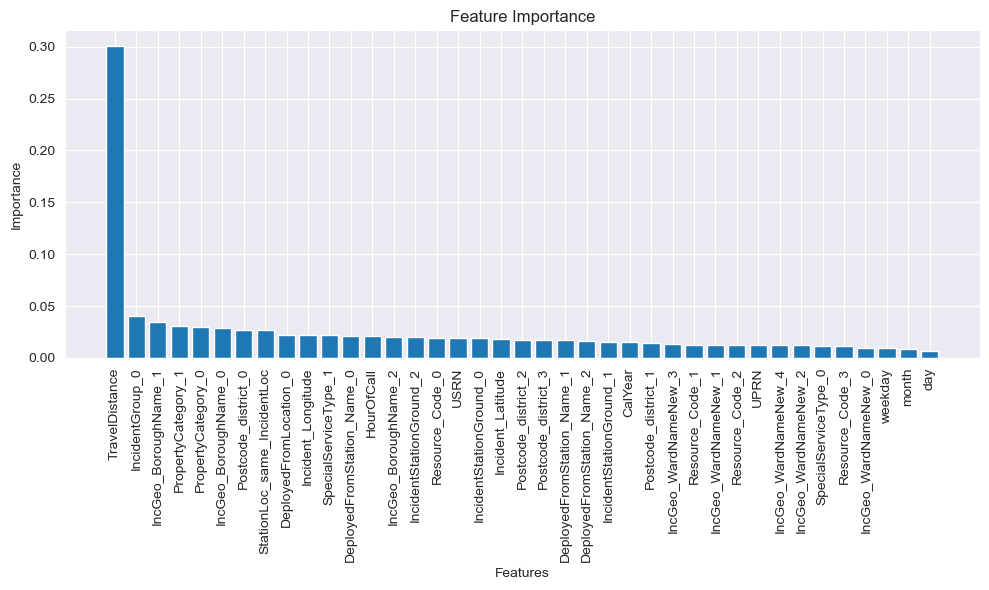

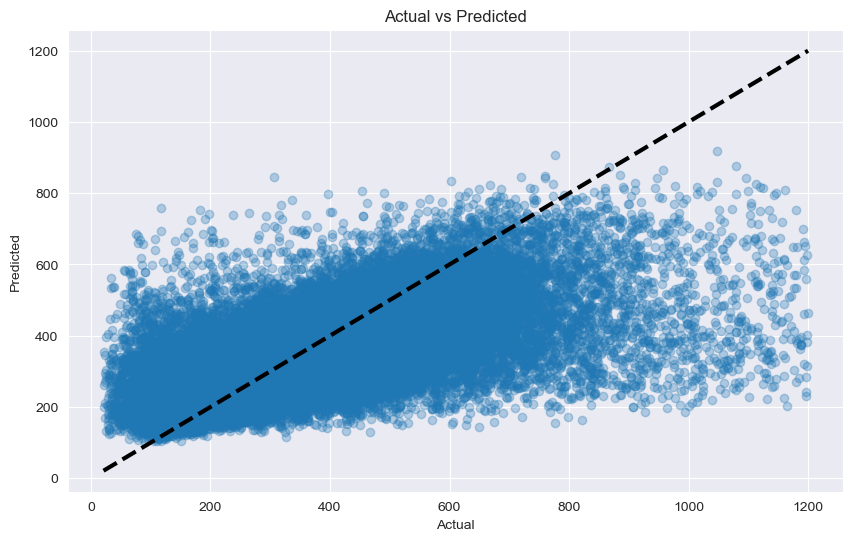

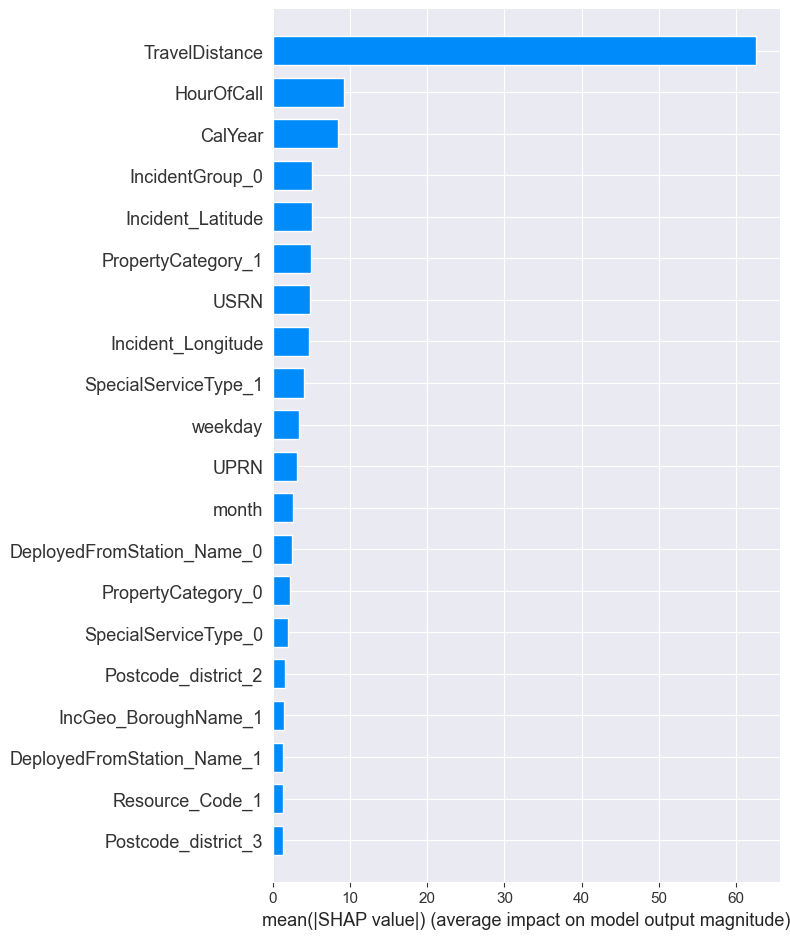

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


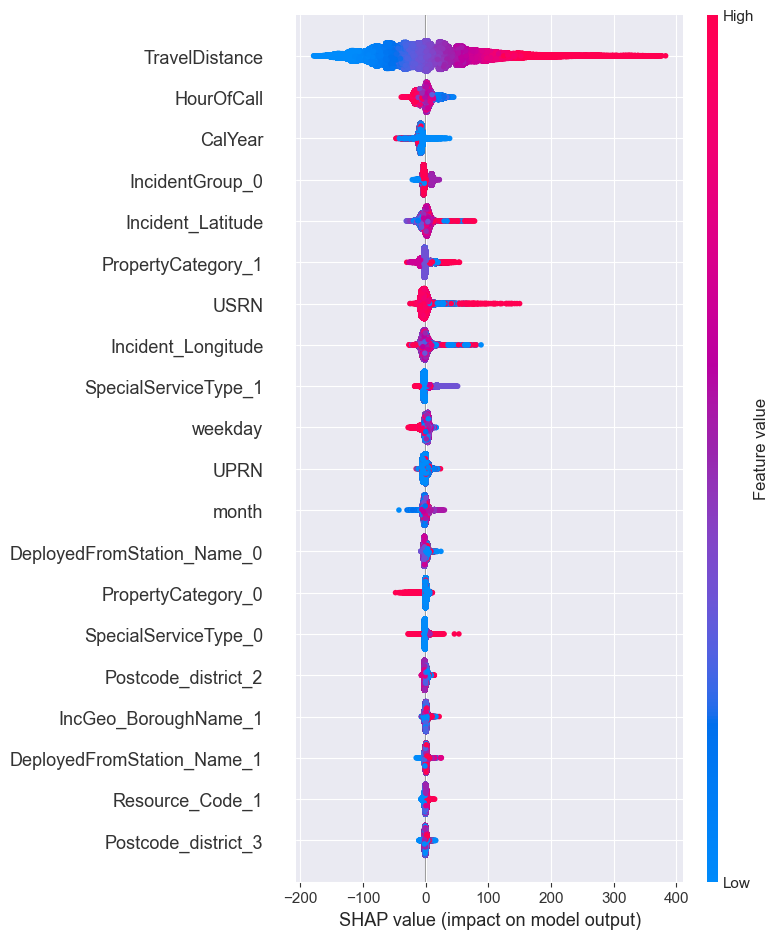

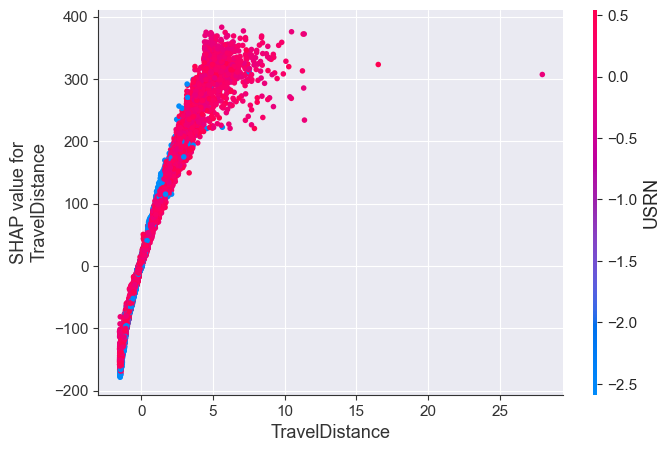

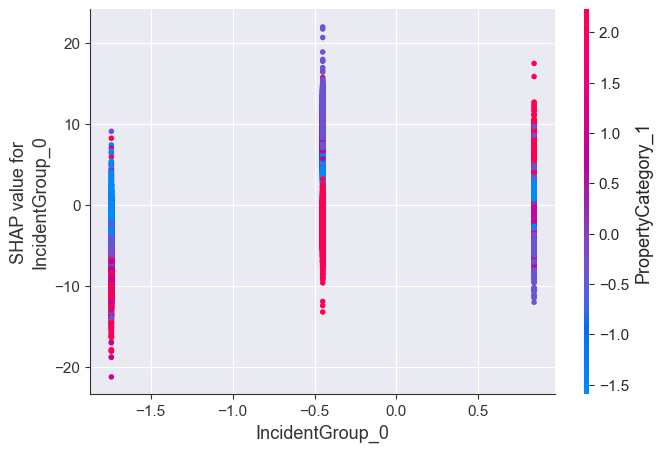

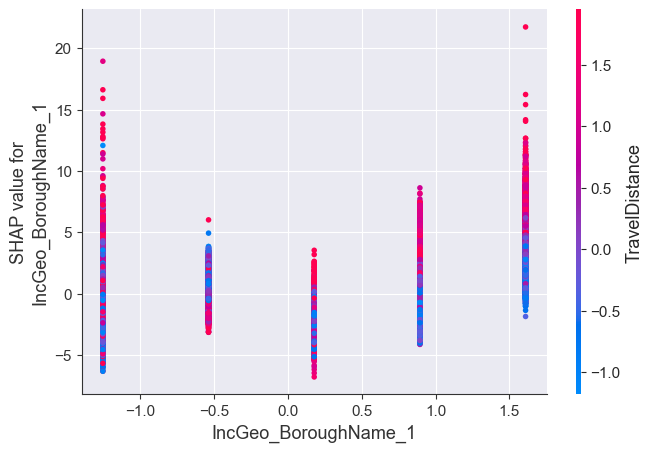

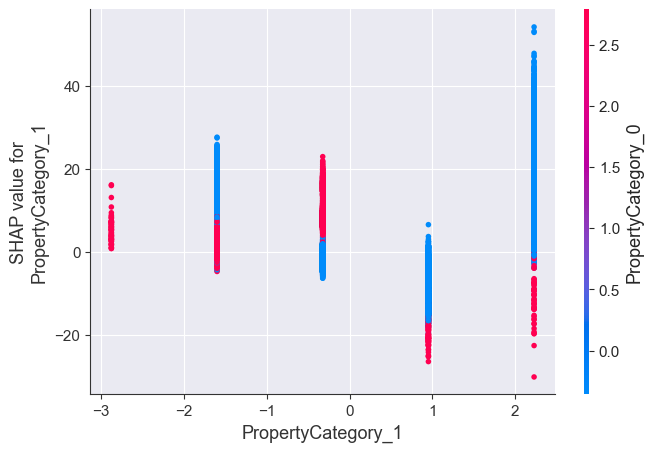

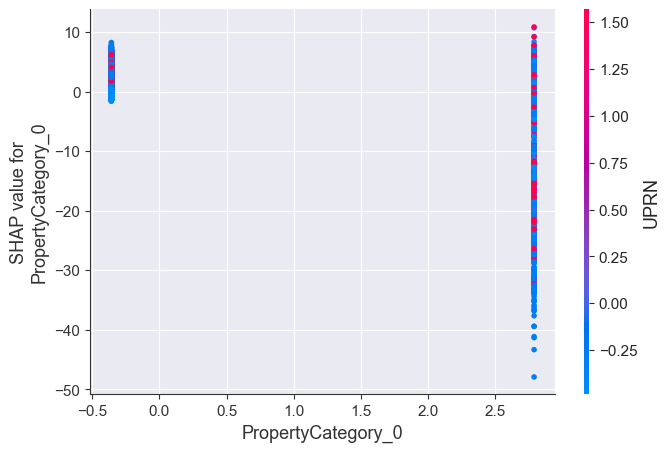

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
MAE: 59.85625647056211
Converted MAE: 59.85625647056211


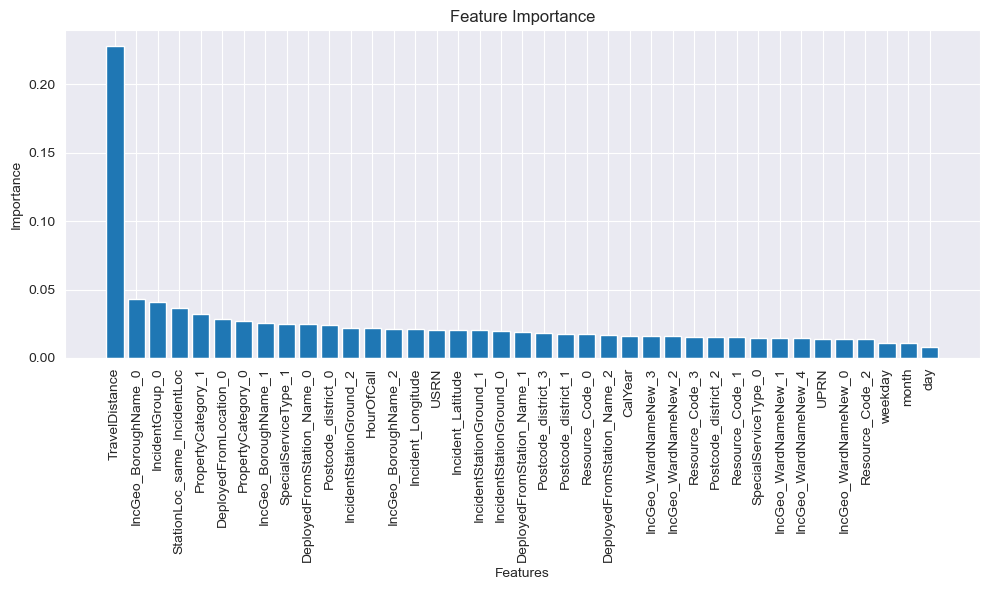

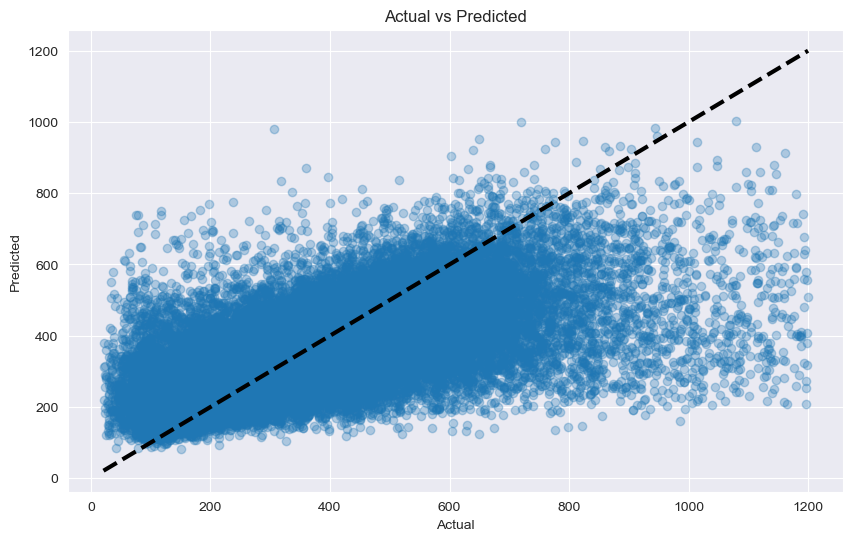

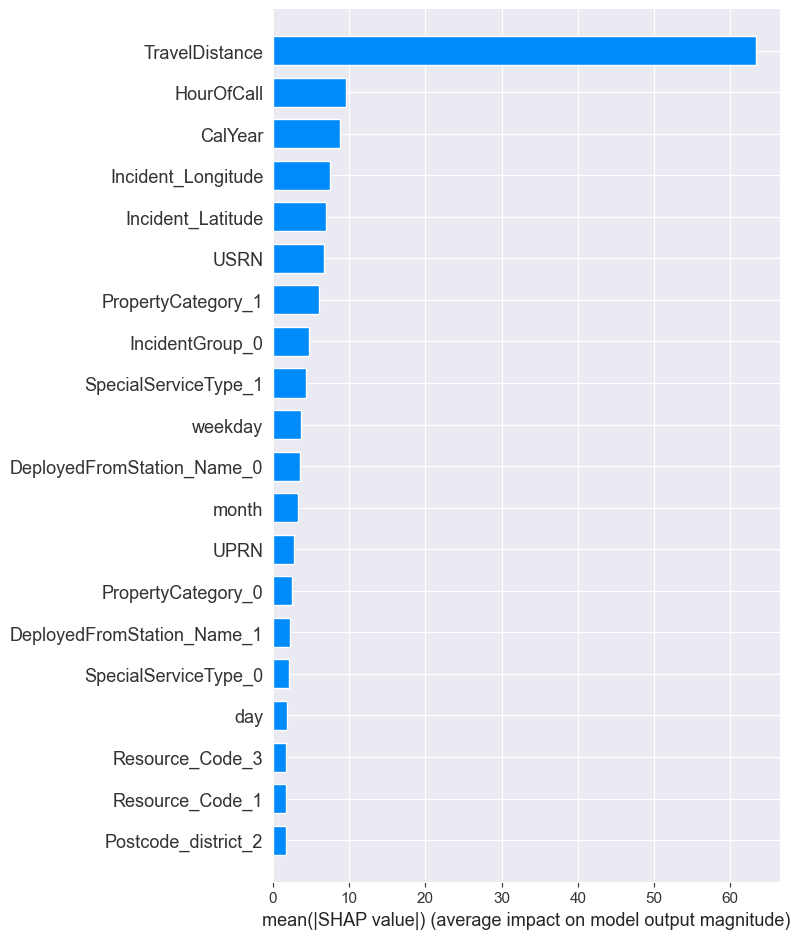

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


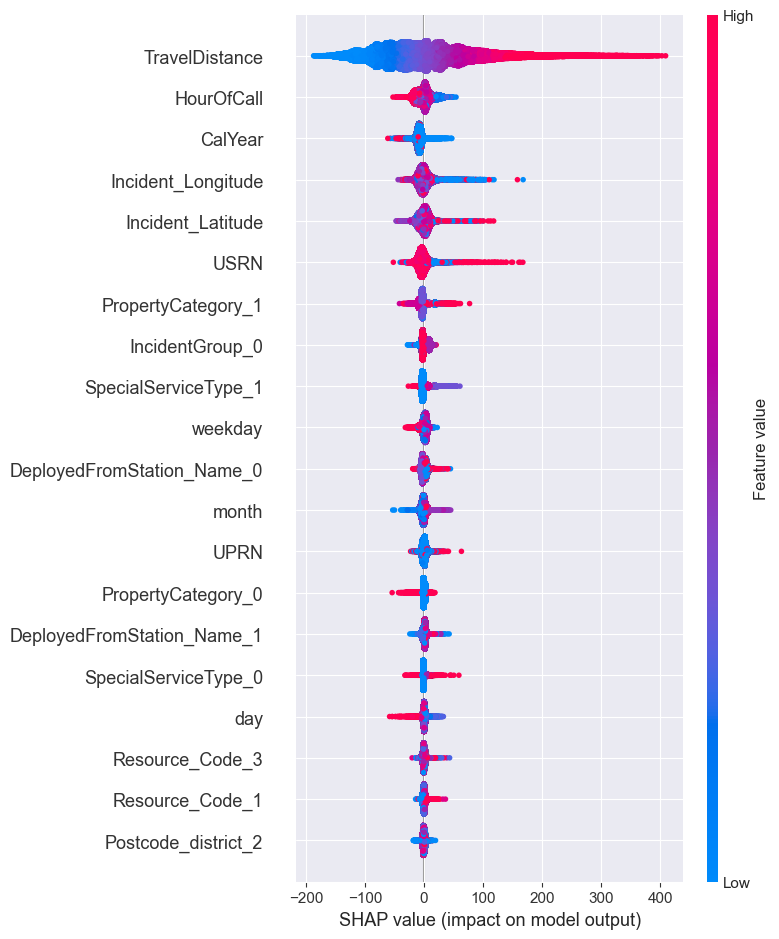

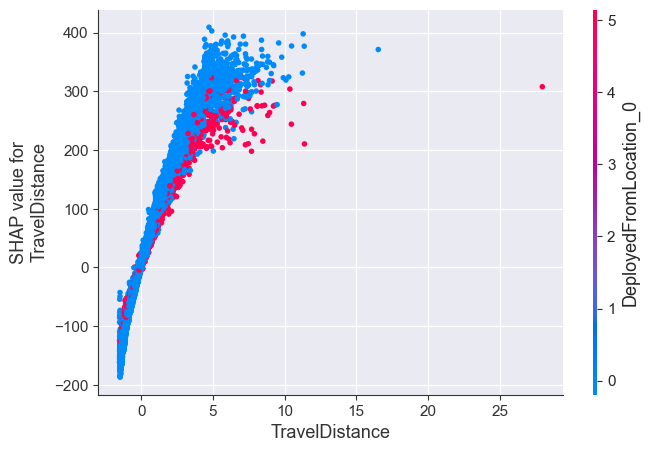

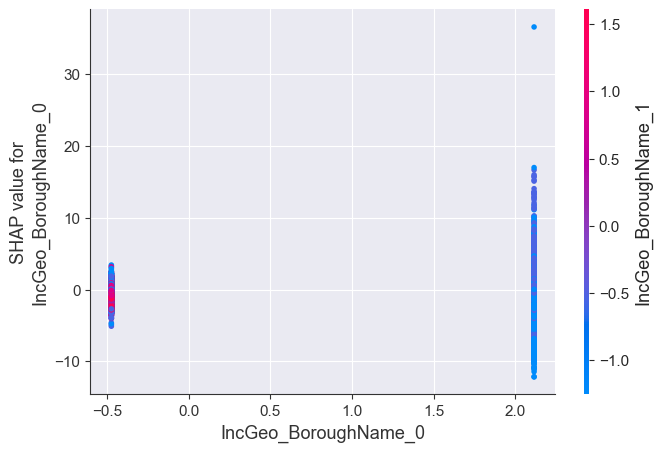

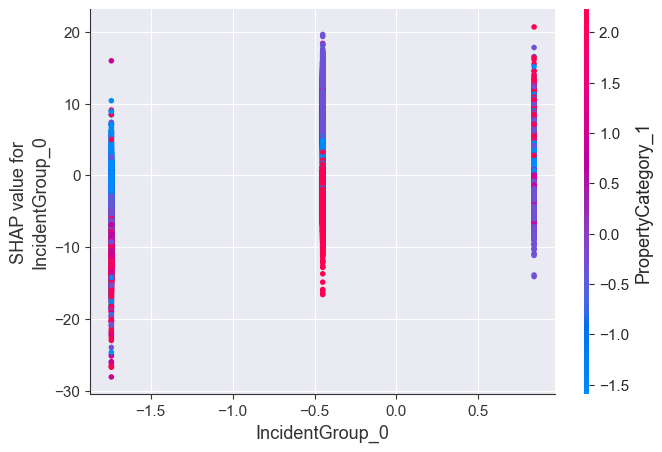

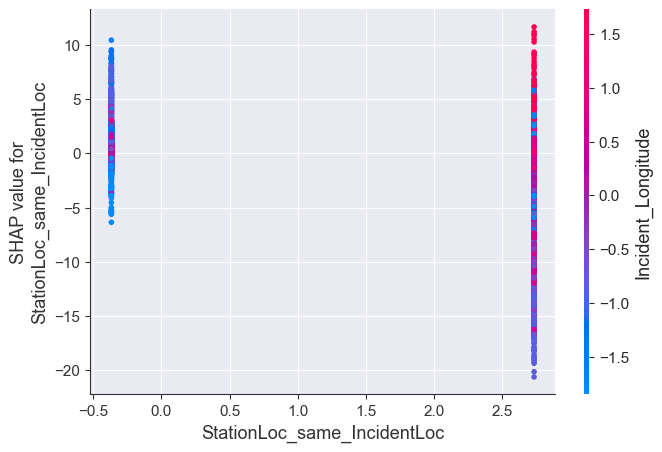

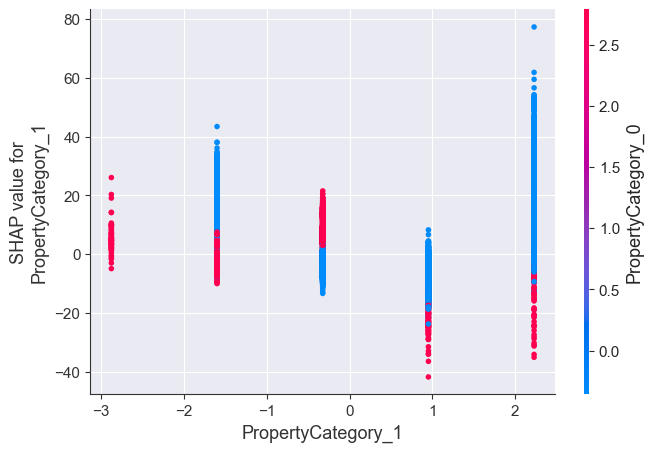

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
R^2: 0.4955721855536218
Converted MAE: 60.32264946793918


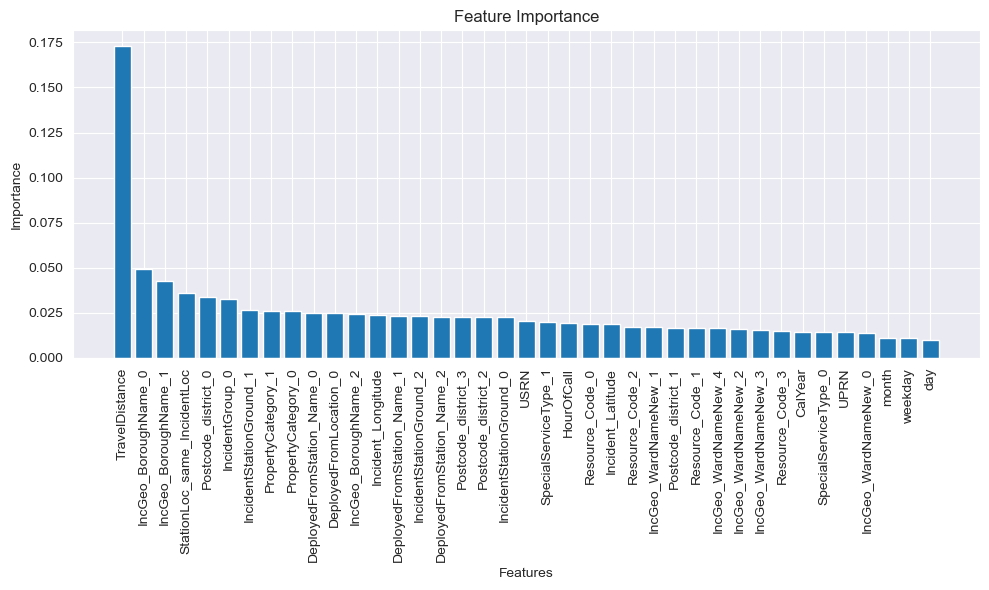

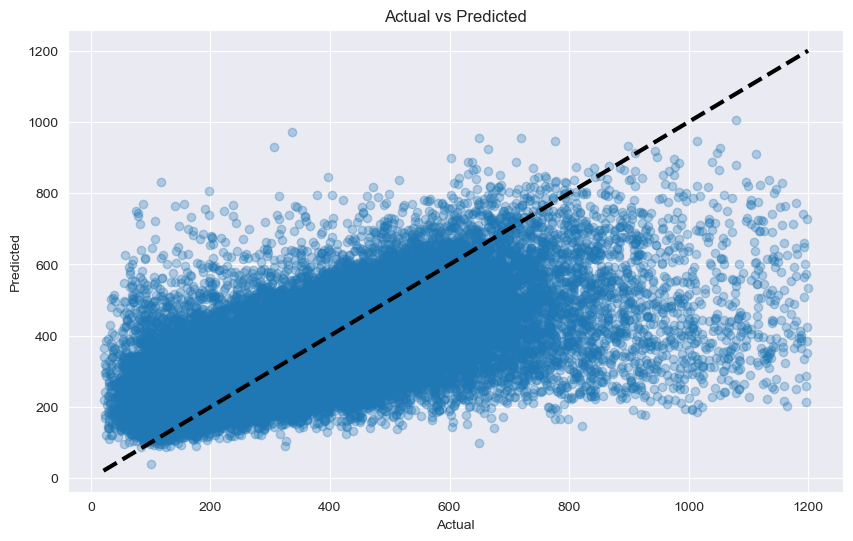

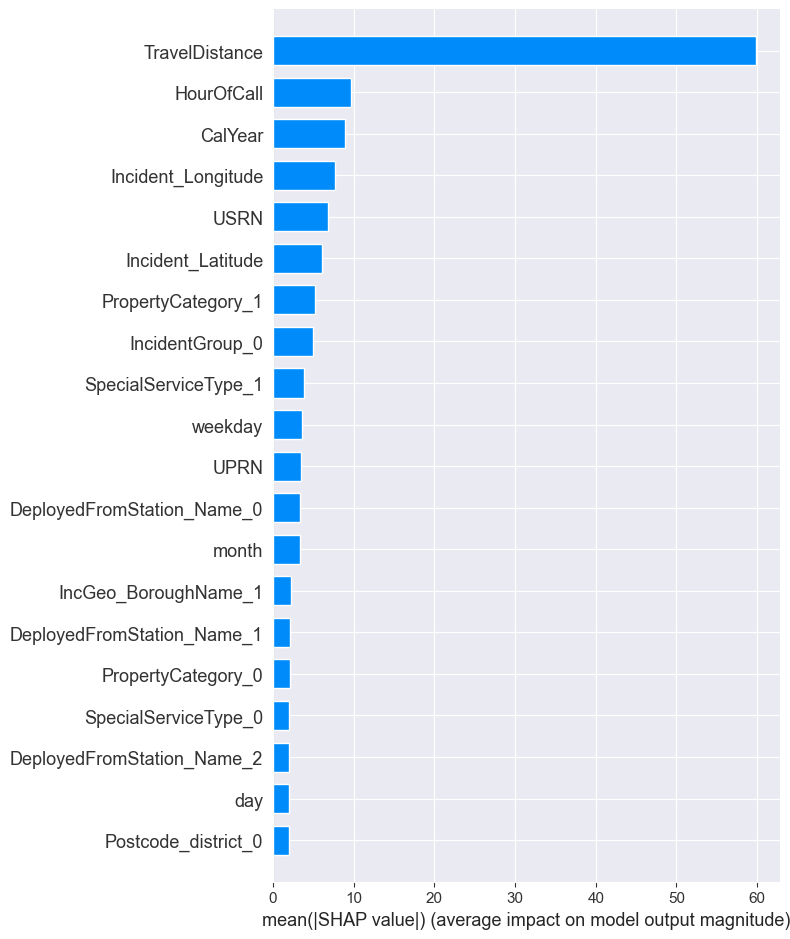

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


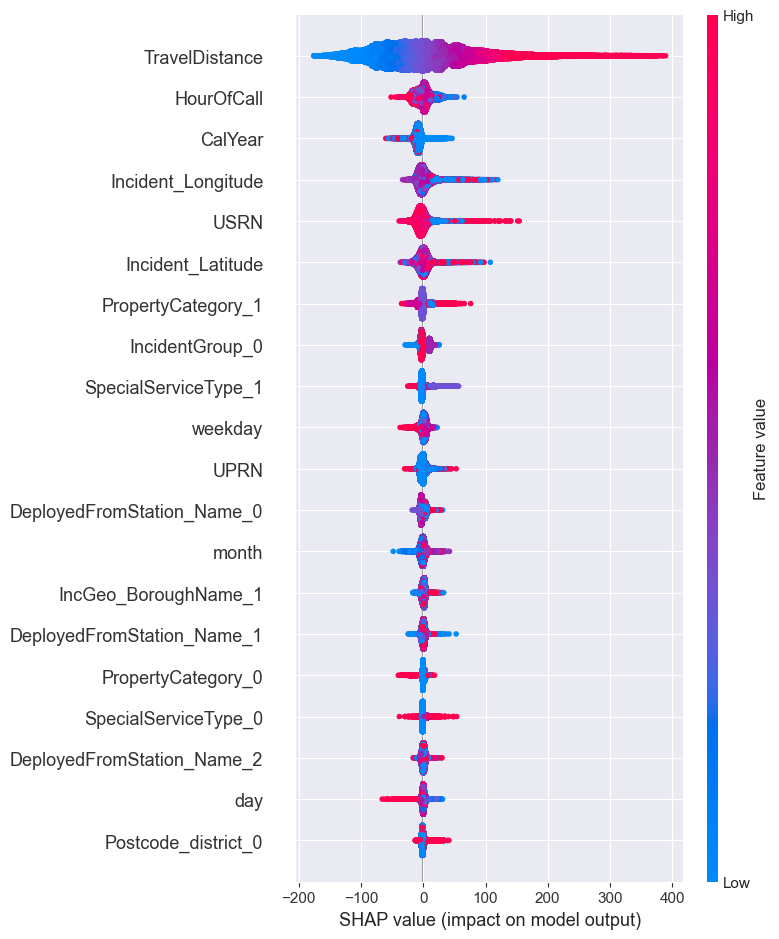

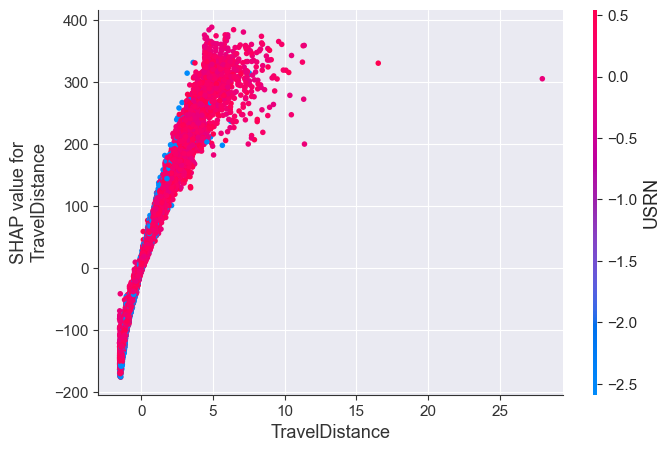

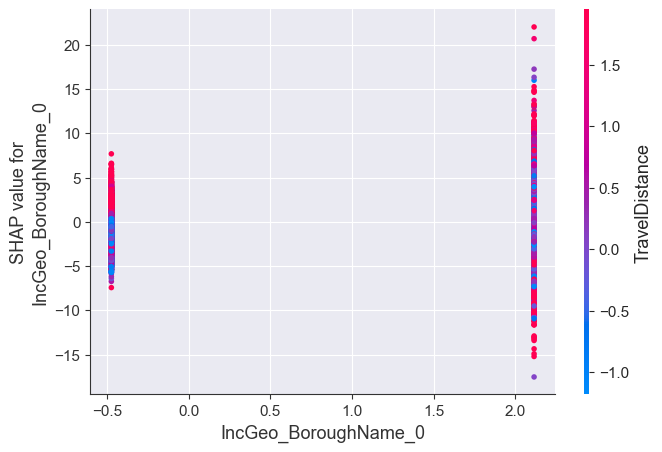

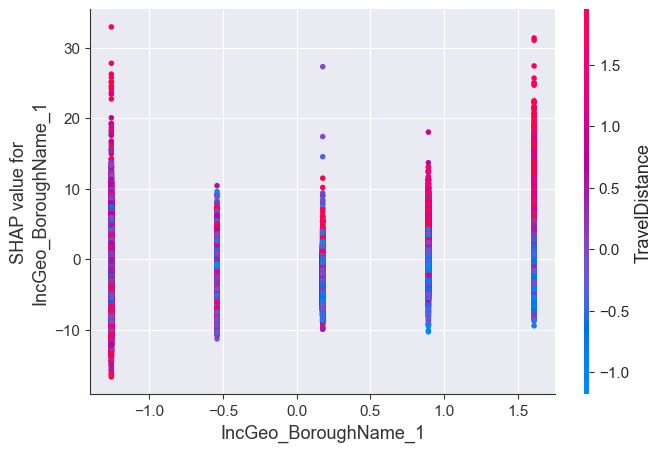

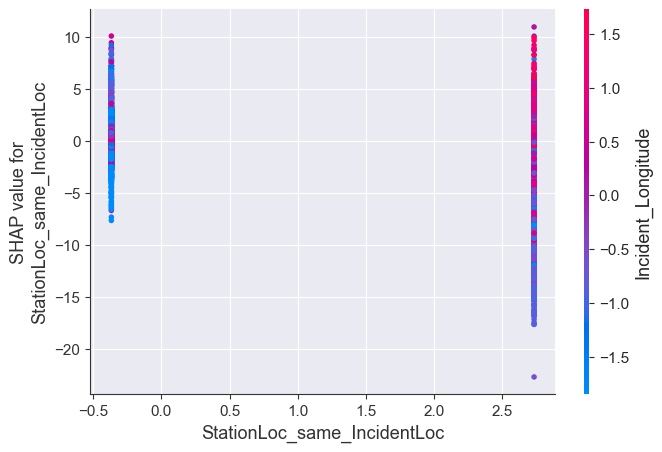

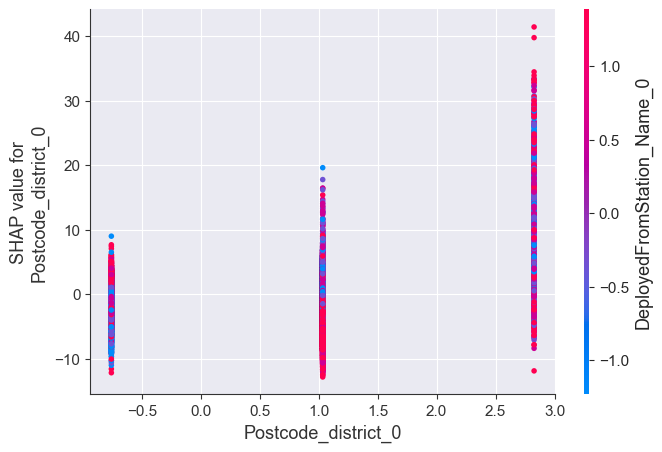

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Median Absolute Error: 42.019317626953125
Converted MAE: 61.785308184497396


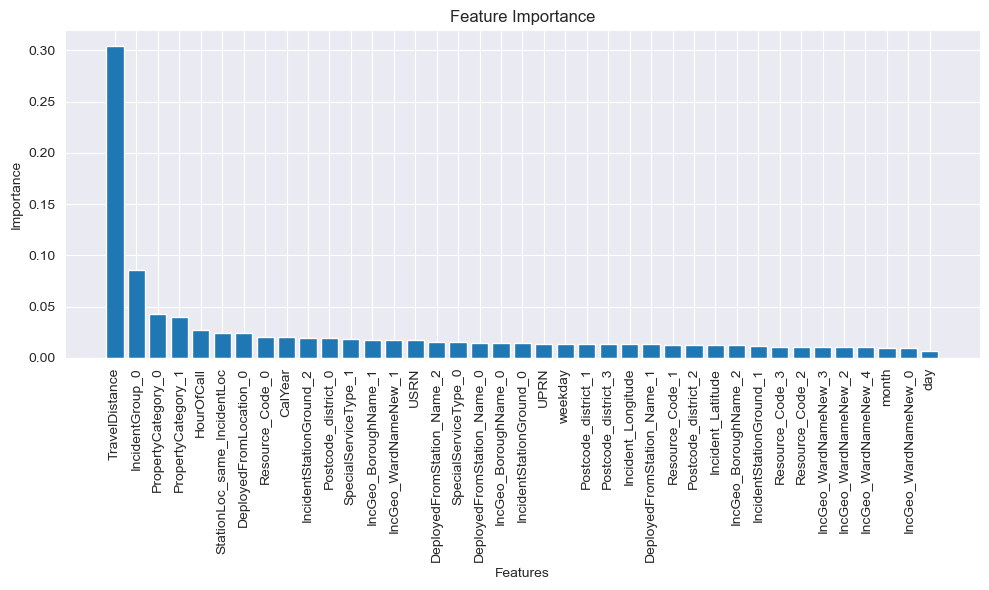

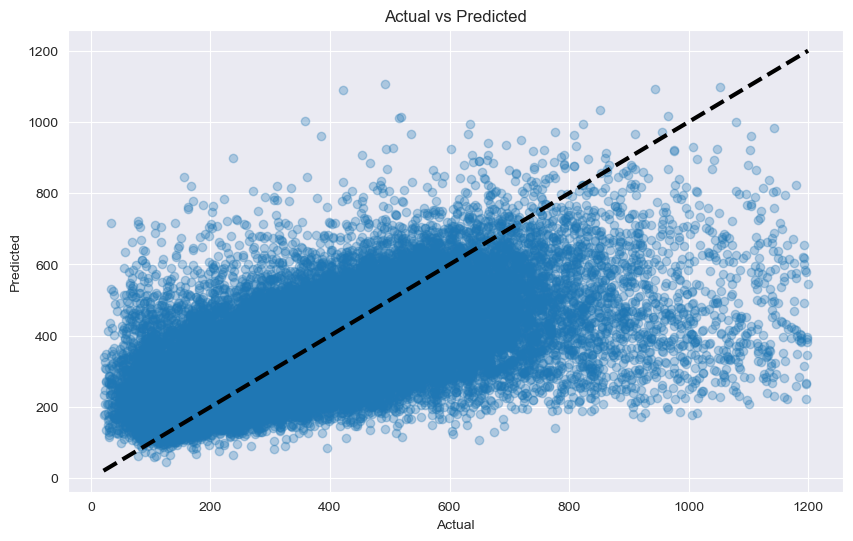

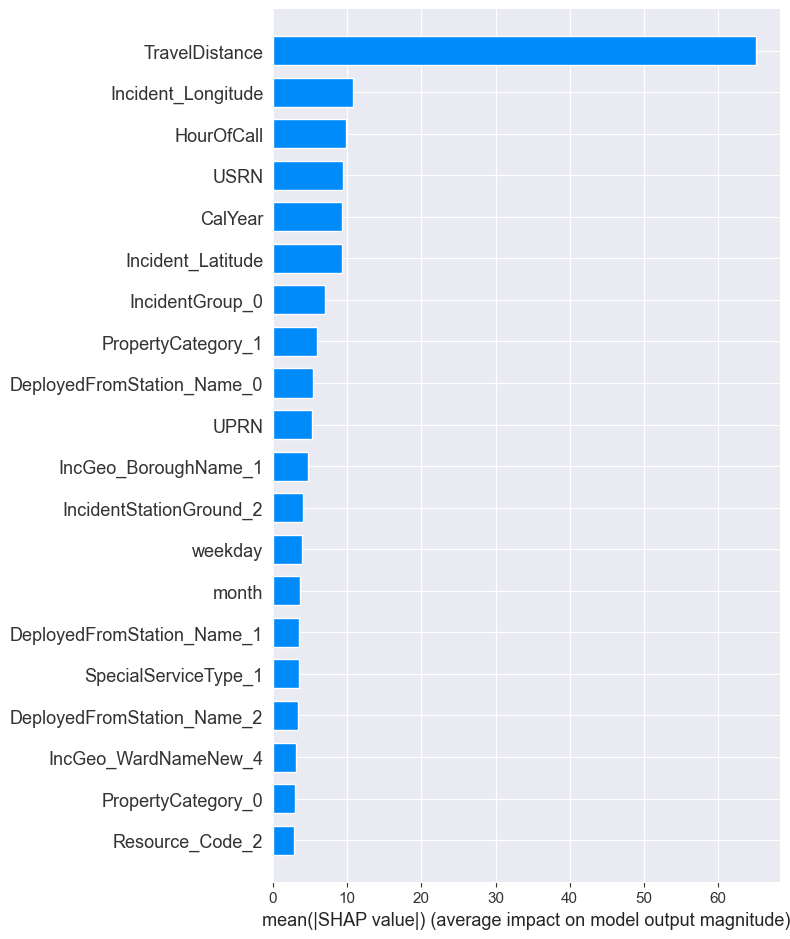

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


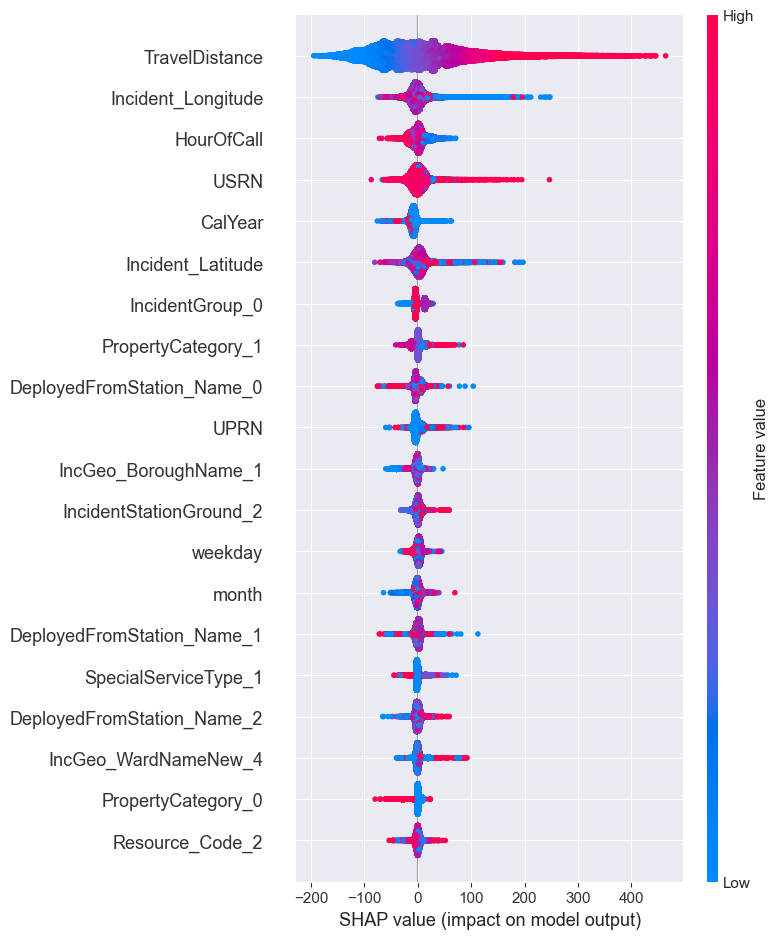

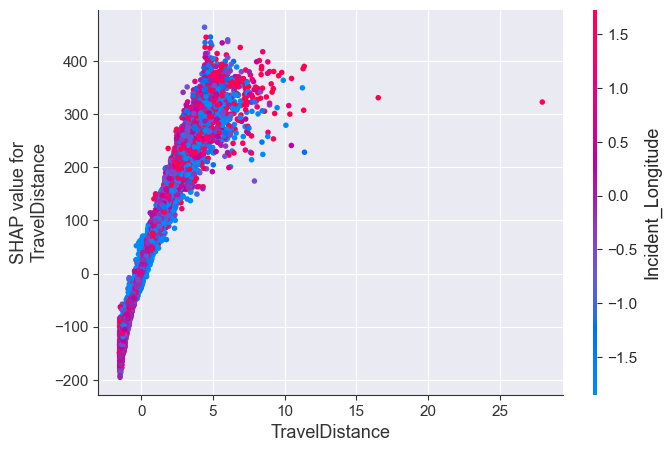

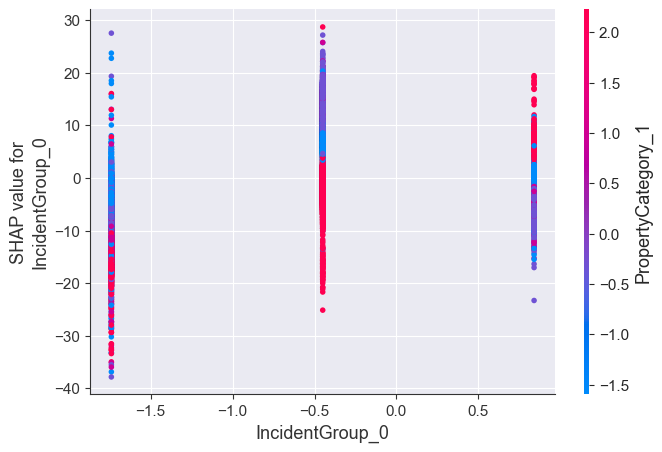

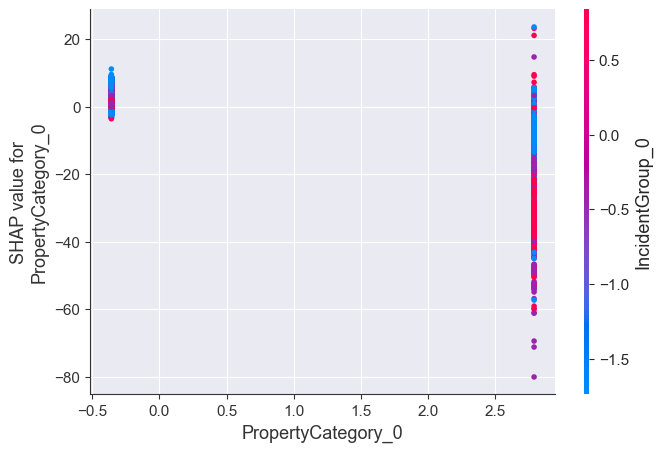

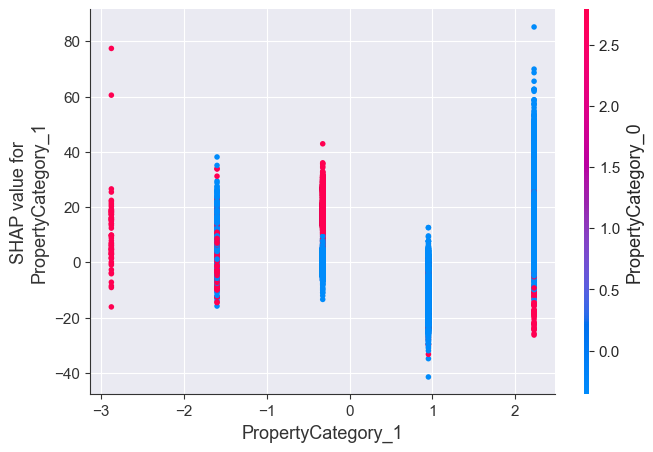

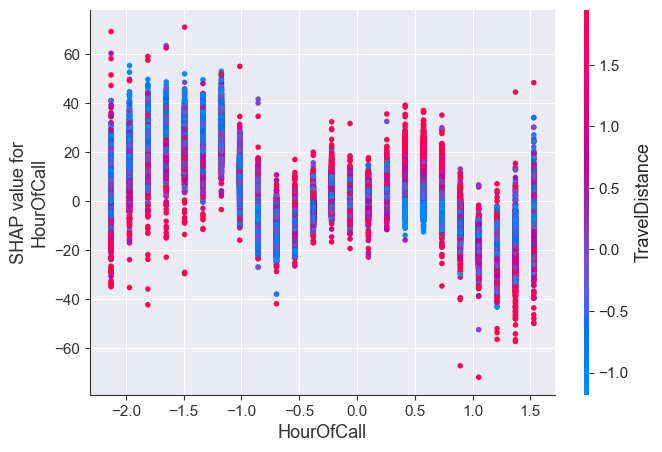

In [6]:
####################-------------Try different scoring metrics and BayesSearchCV-----------########################

from skopt import BayesSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
import shap


# Define feature_names from your DataFrame
feature_names = X_train_std.columns

xgb_model = xgb.XGBRegressor(tree_method="gpu_hist")
xgb_model.fit(X_train_std, y_train)
y_pred_initial = xgb_model.predict(X_test_std)
mse_initial = mean_squared_error(y_test, y_pred_initial)
print('Initial MSE:', mse_initial)

# Define the parameter space for the Bayesian optimization
param_space = {
    'tree_method': ['gpu_hist'],
    'subsample': (0.5, 1.0, 'uniform'),
    'n_estimators': (100, 1000),
    'max_depth': (3, 10, 'uniform'),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
}

# Define feature_names from your DataFrame
feature_names = X_train_std.columns

# Create the BayesSearchCV object with different scoring metrics
scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'neg_median_absolute_error']
for scoring in scoring_metrics:
    xgb_model = xgb.XGBRegressor(tree_method="gpu_hist")
    bayes_search = BayesSearchCV(
        xgb_model,
        param_space,
        cv=3,
        n_iter=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=2
    )

    # Fit the model
    bayes_search.fit(X_train_std, y_train)
    best_xgb_model = bayes_search.best_estimator_

    # Predict on the test set
    y_pred = best_xgb_model.predict(X_test_std)

    # Calculate evaluation metrics
    if scoring == 'neg_mean_squared_error':
        score_name = 'MSE'
        score = mean_squared_error(y_test, y_pred)
    elif scoring == 'neg_mean_absolute_error':
        score_name = 'MAE'
        score = mean_absolute_error(y_test, y_pred)
    elif scoring == 'neg_median_absolute_error':
        score_name = 'Median Absolute Error'
        score = median_absolute_error(y_test, y_pred)
    else:  # r2 scoring
        score_name = 'R^2'
        score = r2_score(y_test, y_pred)

    # Convert the score to MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Print evaluation metrics
    print(f"{score_name}:", score)
    print("Converted MAE:", mae)

    # Obtain feature importance
    feature_importance = best_xgb_model.feature_importances_

    # Generate SHAP plots
    explainer = shap.Explainer(best_xgb_model)
    shap_values = explainer.shap_values(X_test_std)

    # Sort feature importance in descending order
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Plotting the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

    # Generate SHAP plots
    shap.summary_plot(shap_values, X_test_std, plot_type="bar")
    shap.summary_plot(shap_values, X_test_std)




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Initial MAE: 57.65213750638584
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5621968745128243, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01705141432357478,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4

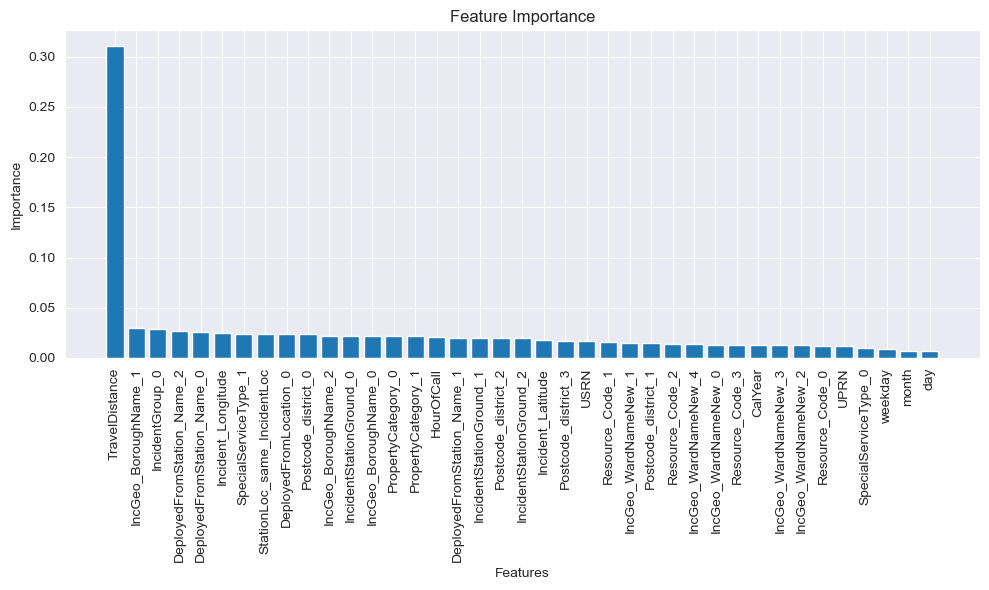

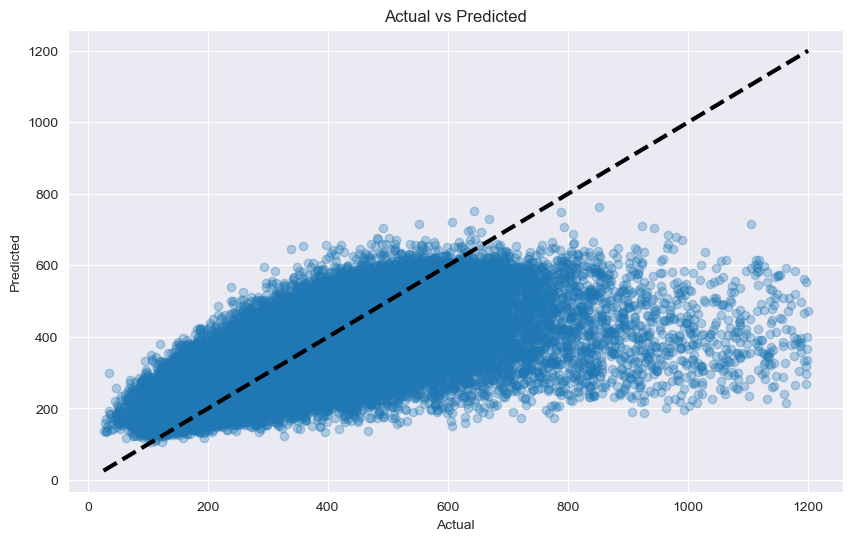

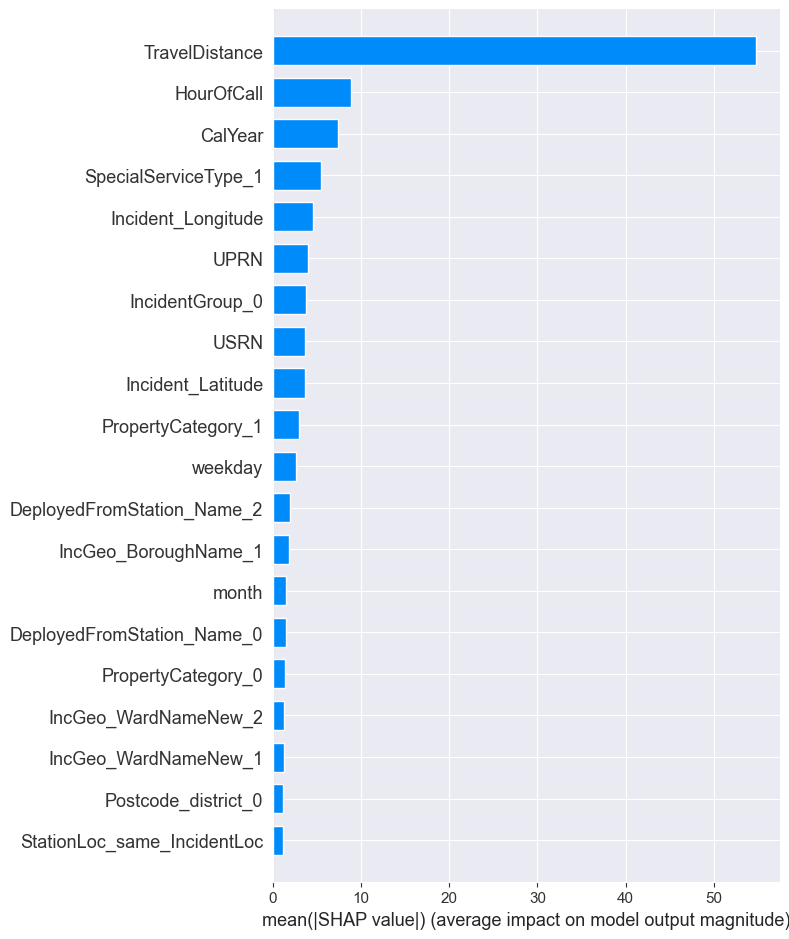

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


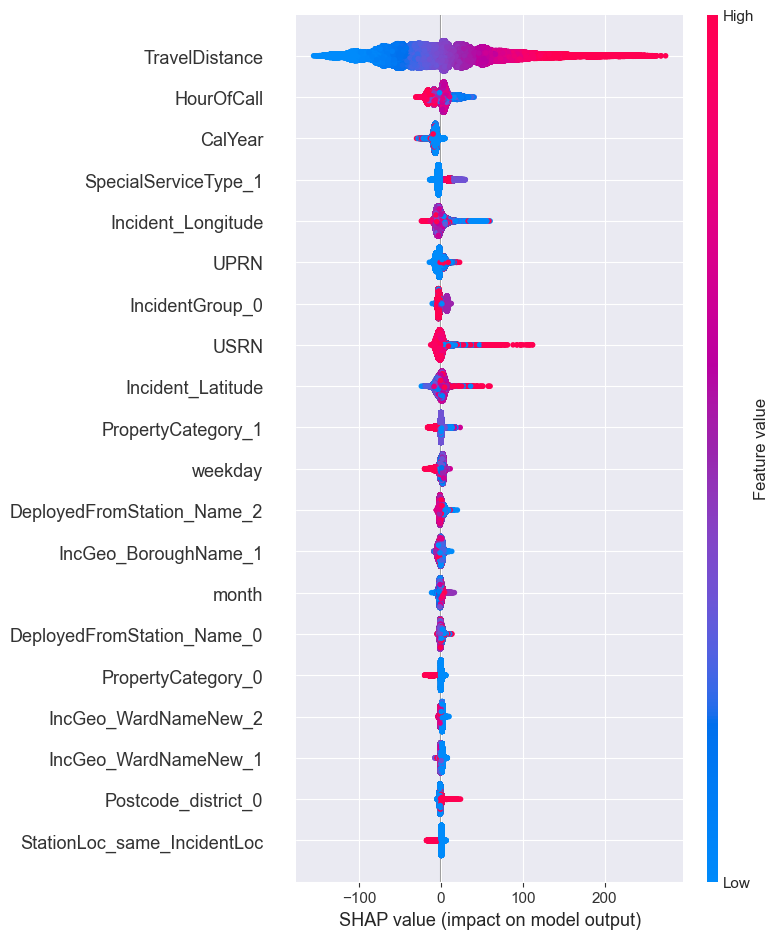

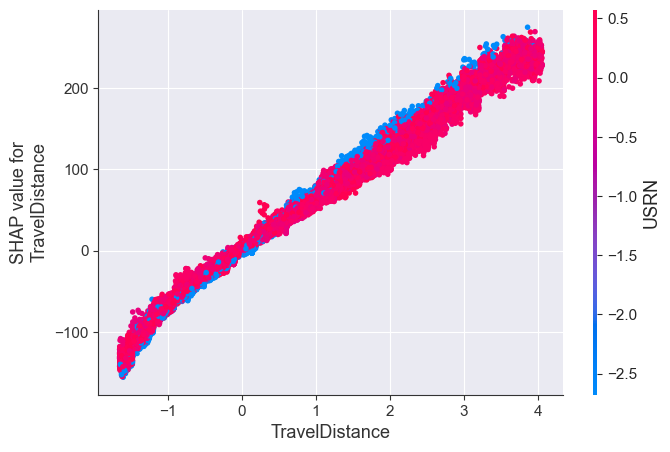

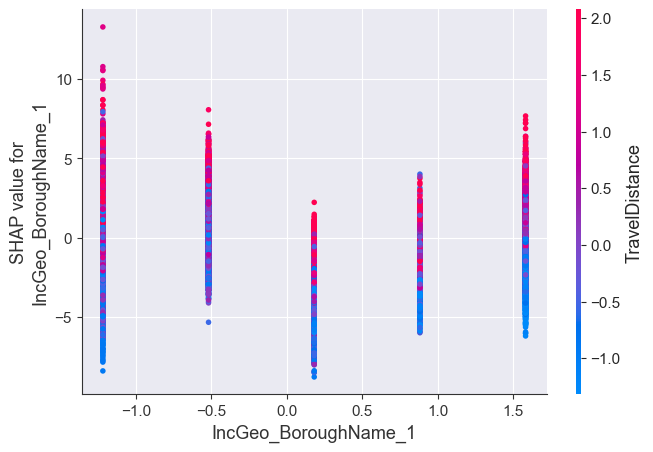

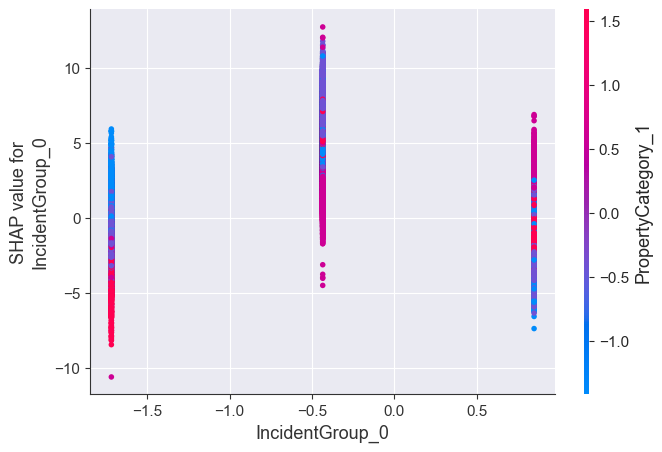

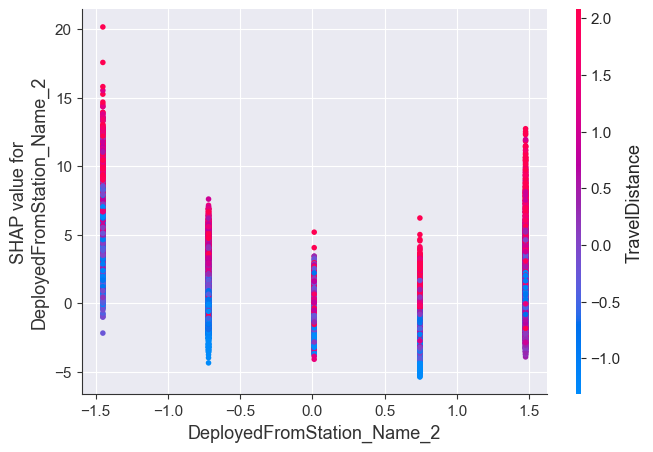

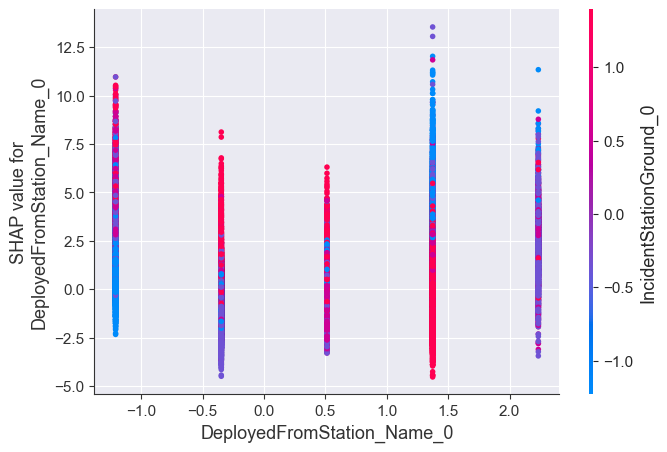

In [3]:
####################-------------Try hyperparameter tuning with best metric and BayesSearchCV-----------########################

from skopt import BayesSearchCV
import numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

# Define feature_names from your DataFrame
feature_names = X_train_std.columns

xgb_model = xgb.XGBRegressor(tree_method="gpu_hist")
xgb_model.fit(X_train_std, y_train)
y_pred_initial = xgb_model.predict(X_test_std)
mae_initial = mean_absolute_error(y_test, y_pred_initial)
print('Initial MAE:', mae_initial)

# Define the parameter space for the Bayesian optimization
param_space = {
    'tree_method': ['gpu_hist'],
    'subsample': (0.5, 1.0, 'uniform'),
    'n_estimators': (100, 1000),
    'max_depth': (3, 10, 'uniform'),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
}


# Create the BayesSearchCV object with neg_mean_absolute_error scoring
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist")
bayes_search = BayesSearchCV(
    xgb_model,
    param_space,
    cv=3,
    n_iter=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model
bayes_search.fit(X_train_std, y_train)
best_xgb_model = bayes_search.best_estimator_
print(best_xgb_model)

# Predict on the test set
y_pred = best_xgb_model.predict(X_test_std)

# Calculate evaluation metric
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# Obtain feature importance
feature_importance = best_xgb_model.feature_importances_

# Generate SHAP plots
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_std)

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Generate SHAP plots
shap.summary_plot(shap_values, X_test_std)

for feature in sorted_feature_names[:5]:
    shap.dependence_plot(feature, shap_values, X_test_std)


In [ ]:
##########---------------- Using the best_xgb_model to fine tune the model-----###################

# Define feature_names from your DataFrame
feature_names = X_train_std.columns

xgb_model = xgb.XGBRegressor(tree_method="gpu_hist")
xgb_model.fit(X_train_std, y_train)
y_pred_initial = xgb_model.predict(X_test_std)
mae_initial = mean_absolute_error(y_test, y_pred_initial)
print('Initial MAE:', mae_initial)

param_space = {
    'tree_method': ['gpu_hist'],
    'subsample': (0.8, 1.0, 'uniform'),
    'n_estimators': (870, 1100),
    'max_depth': (8, 12, 'uniform'),
    'learning_rate': (0.03, 0.07, 'log-uniform'),
    'colsample_bytree': (0.8, 1.0, 'uniform'),
    'gamma': (0, 1, 'uniform'),
    'min_child_weight': (1, 6),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    'scale_pos_weight': (1, 5),
    'max_delta_step': (0, 10),
    'colsample_bylevel': (0.8, 1.0, 'uniform'),
    'colsample_bynode': (0.8, 1.0, 'uniform'),
}


# Create the BayesSearchCV object with neg_mean_absolute_error scoring
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist")
bayes_search = BayesSearchCV(
    xgb_model,
    param_space,
    cv=5,
    n_iter=8,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model
bayes_search.fit(X_train_std, y_train)
best_xgb_model = bayes_search.best_estimator_

# Predict on the test set
y_pred = best_xgb_model.predict(X_test_std)

# Calculate evaluation metric
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

model_attributes = vars(best_xgb_model)
for attribute, value in model_attributes.items():
    print(f"{attribute}: {value}")

# Obtain feature importance
feature_importance = best_xgb_model.feature_importances_

# Generate SHAP plots
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_std)

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Generate SHAP plots
shap.summary_plot(shap_values, X_test_std, plot_type="bar")
shap.summary_plot(shap_values, X_test_std)

for feature in sorted_feature_names[:5]:
    shap.dependence_plot(feature, shap_values, X_test_std)

Initial MAE: 57.65213750638584
Fitting 5 folds for each of 1 candidates, totalling 5 fits


MAE: 56.18992991223921


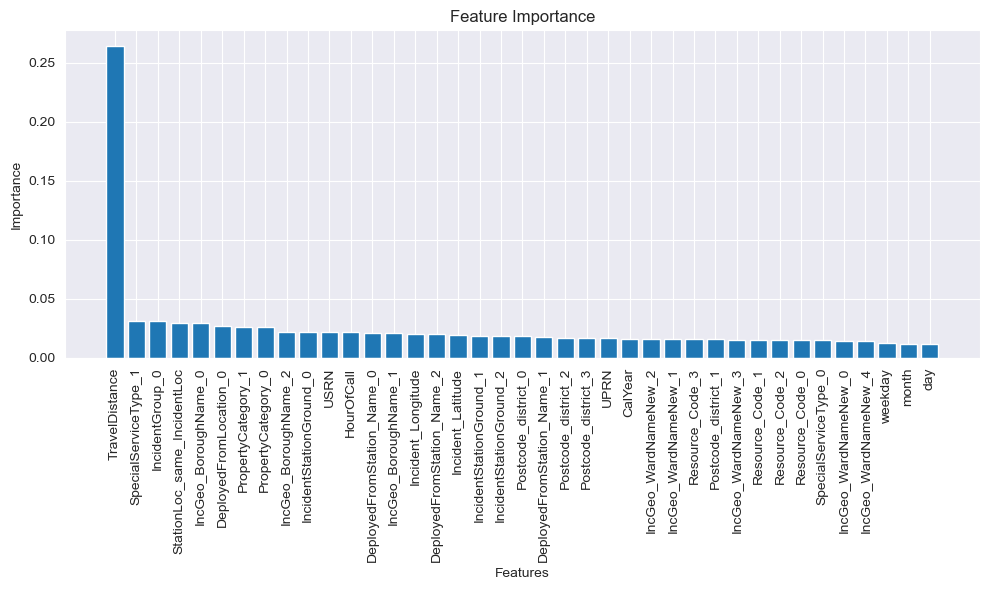

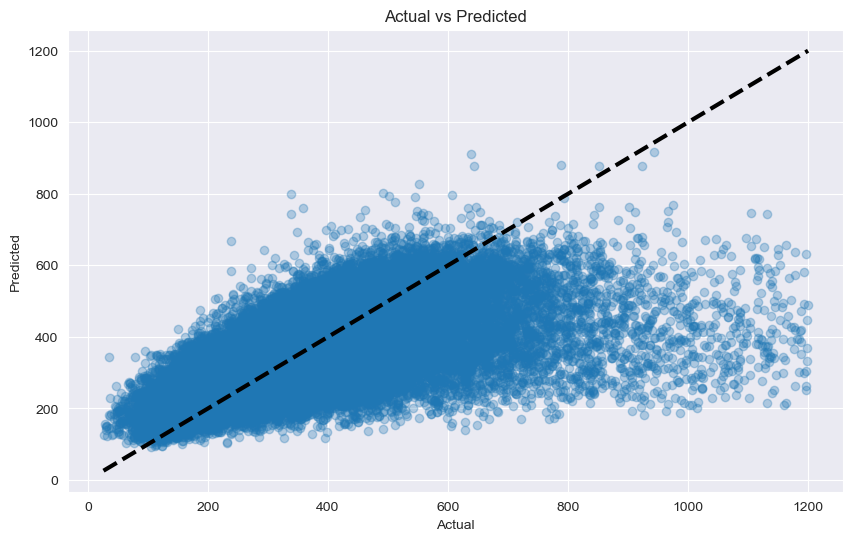

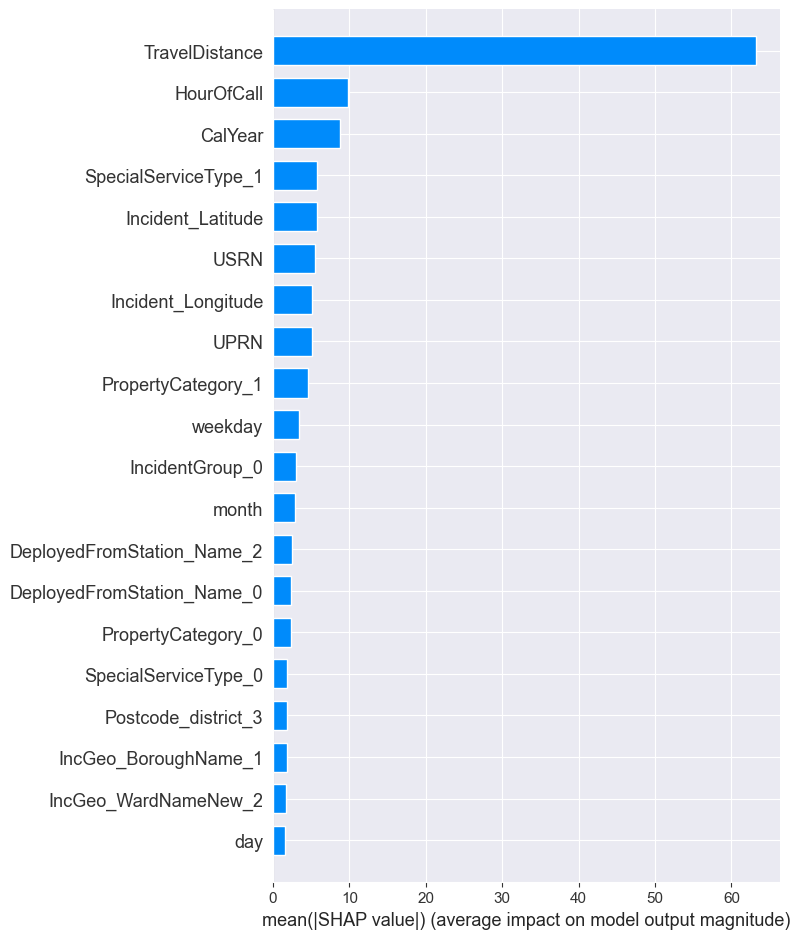

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


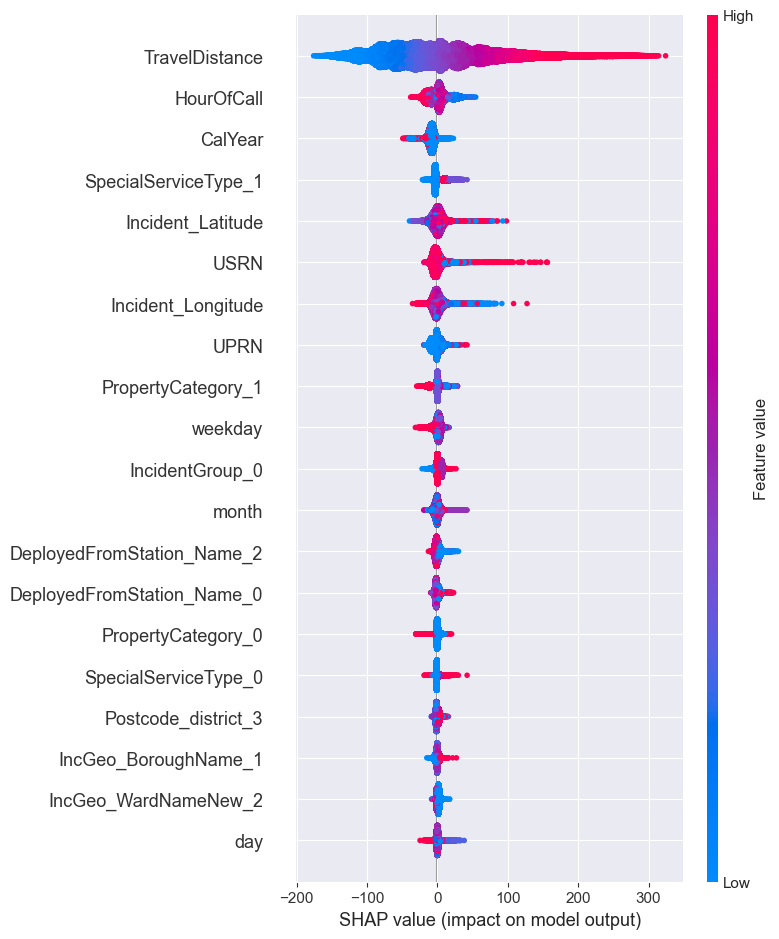

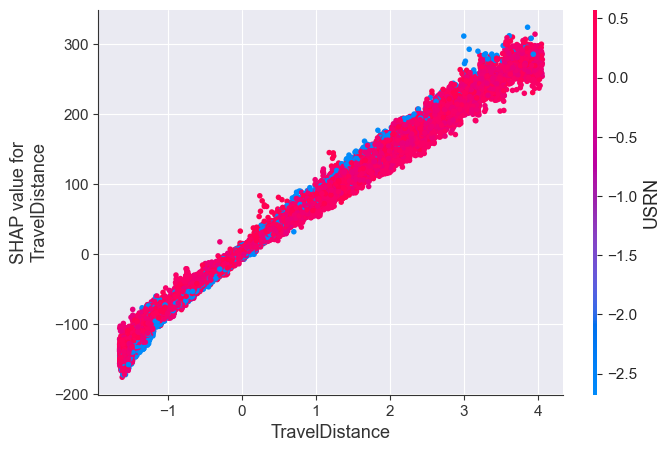

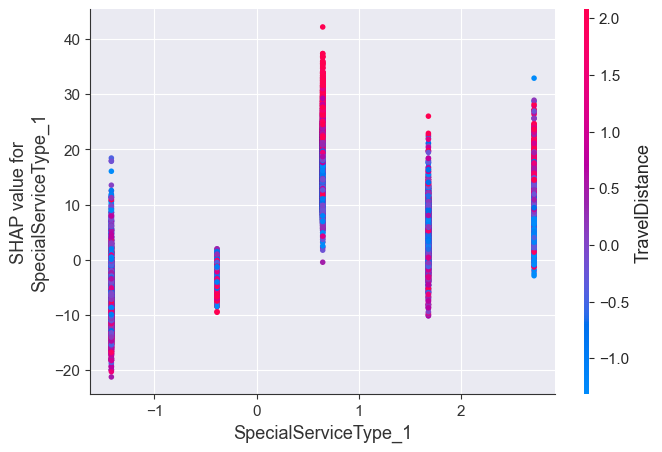

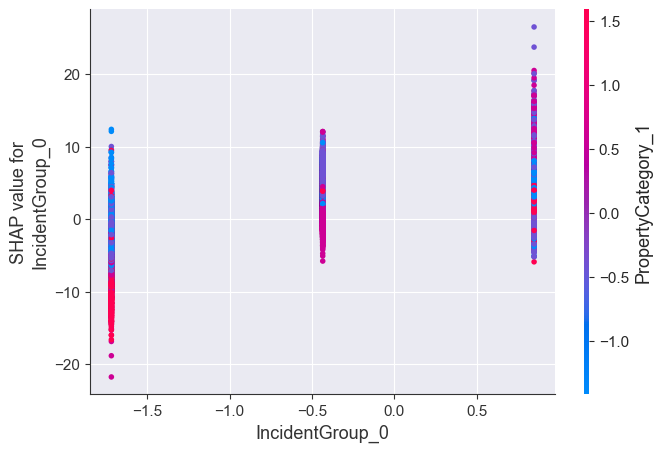

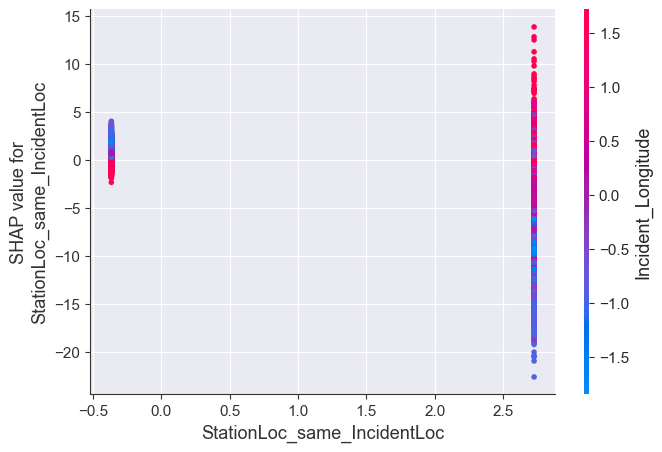

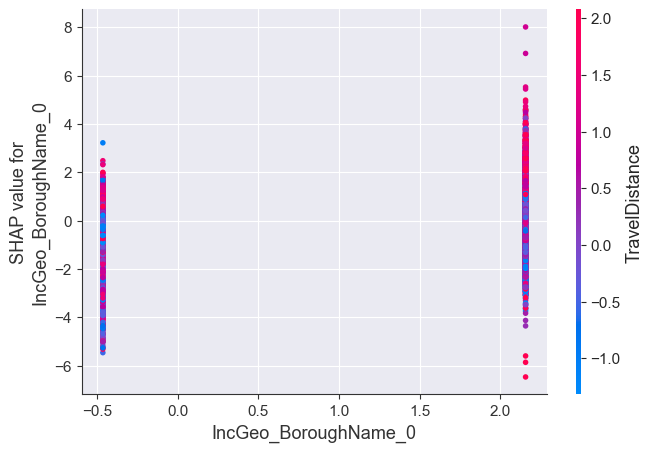

In [4]:
############------------Training one model with best parameters----------################
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import shap
import matplotlib.pyplot as plt
import numpy as np


# Define feature_names from your DataFrame
feature_names = X_train_std.columns

# Create the XGBoost model with the best parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=955,
    objective='reg:squarederror',
    max_depth=9,
    learning_rate=0.03924172708513039,
    gamma=1,
    min_child_weight=3,
    max_delta_step=7,
    subsample=0.954926731974235,
    colsample_bytree=0.9485923931410871,
    colsample_bylevel=0.8884720541146421,
    colsample_bynode=0.8535263718012538,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=4,
    tree_method="gpu_hist"
)

# Train the model
xgb_model.fit(X_train_std, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_std)

# Calculate evaluation metric
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# Get feature importances
feature_importance = xgb_model.feature_importances_

# Generate SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test_std)

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Generate SHAP plots
shap.summary_plot(shap_values, X_test_std)

for feature in sorted_feature_names[:5]:
    shap.dependence_plot(feature, shap_values, X_test_std)

In [45]:
!pip install lightgbm

  Using cached lightgbm-4.0.0-py3-none-win_amd64.whl (1.3 MB)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 529291, number of used features: 39
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.15 MB) transferred to GPU in 0.012329 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 320.829787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

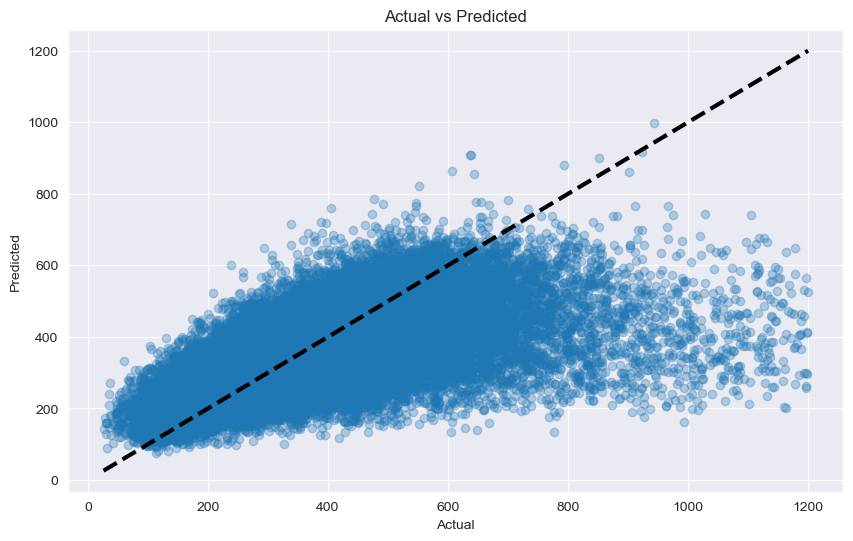

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


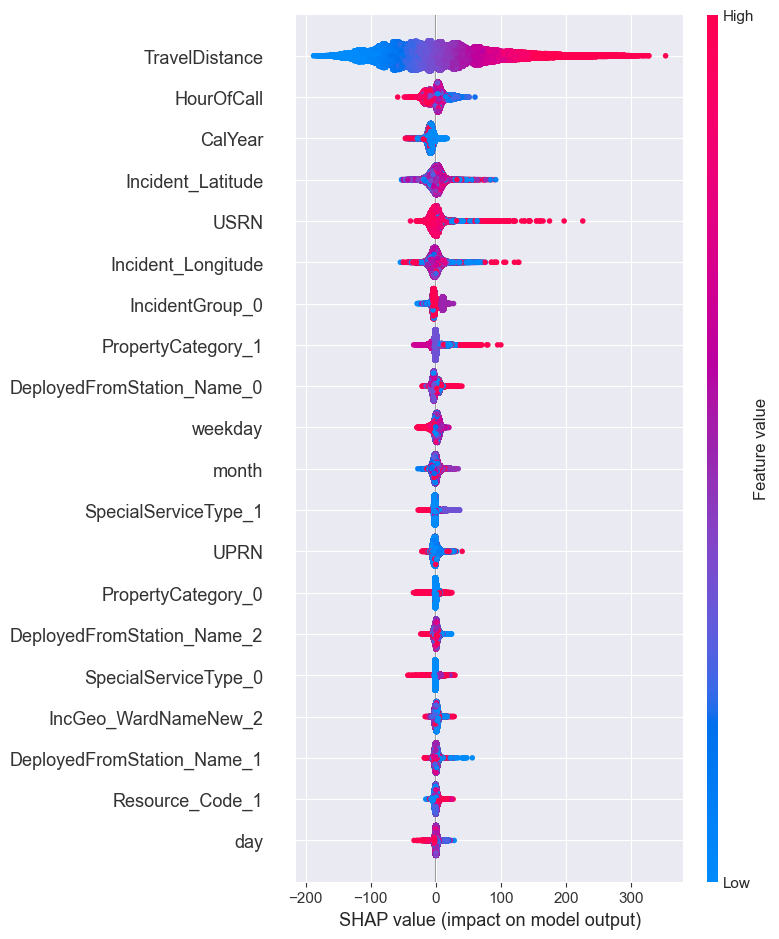

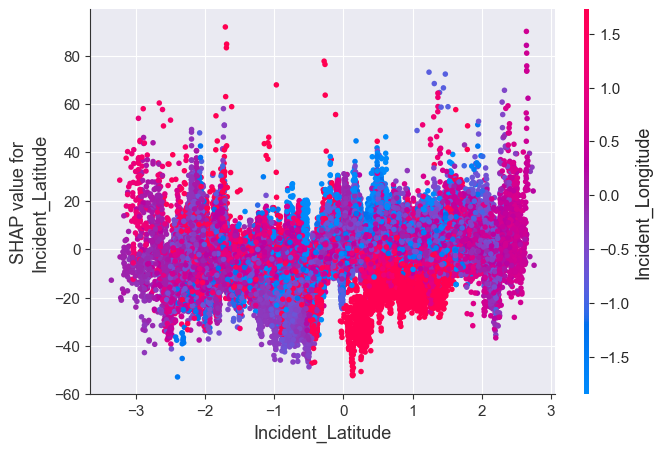

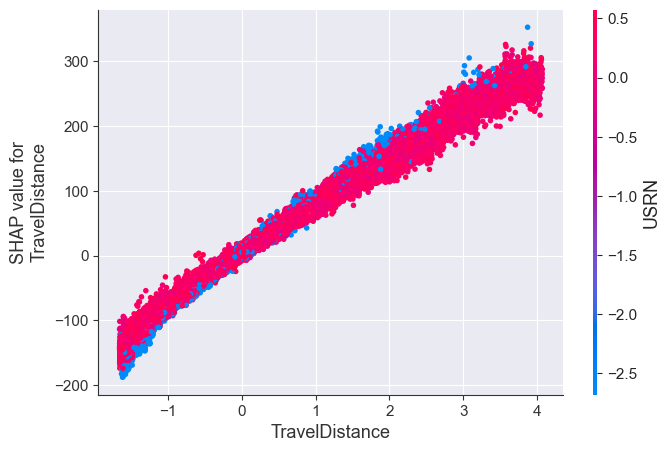

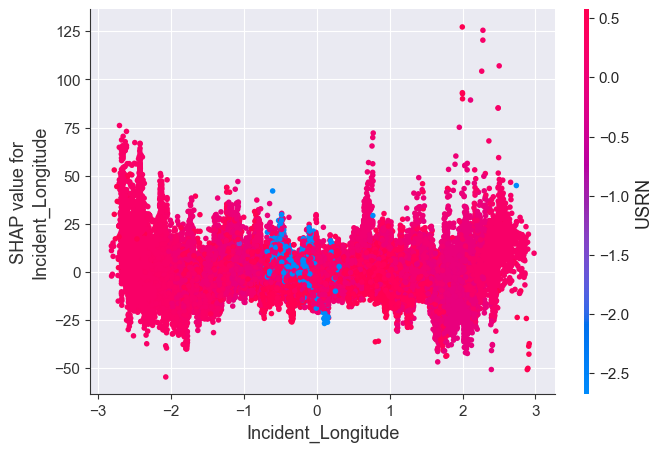

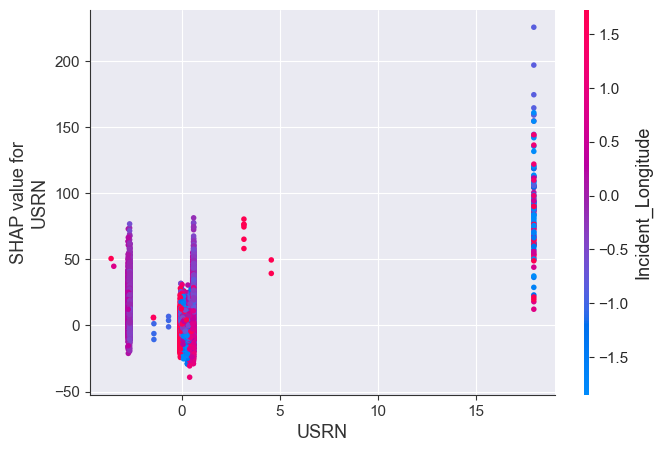

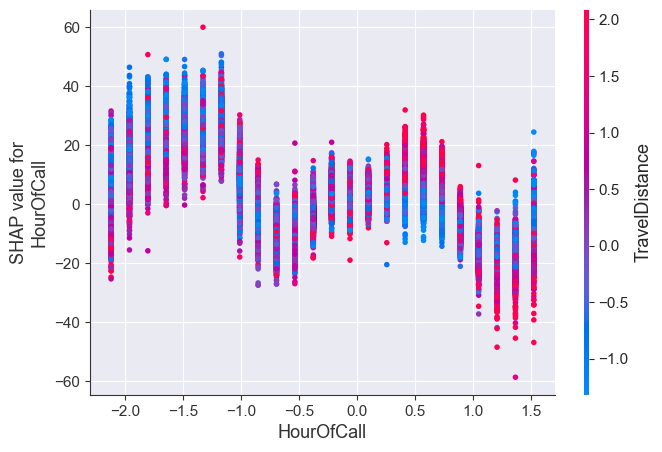

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 529291, number of used features: 39
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (16.15 MB) transferred to GPU in 0.012591 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 320.829787
Initial MAE: 58.63099263874889
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1512
[LightGBM] [

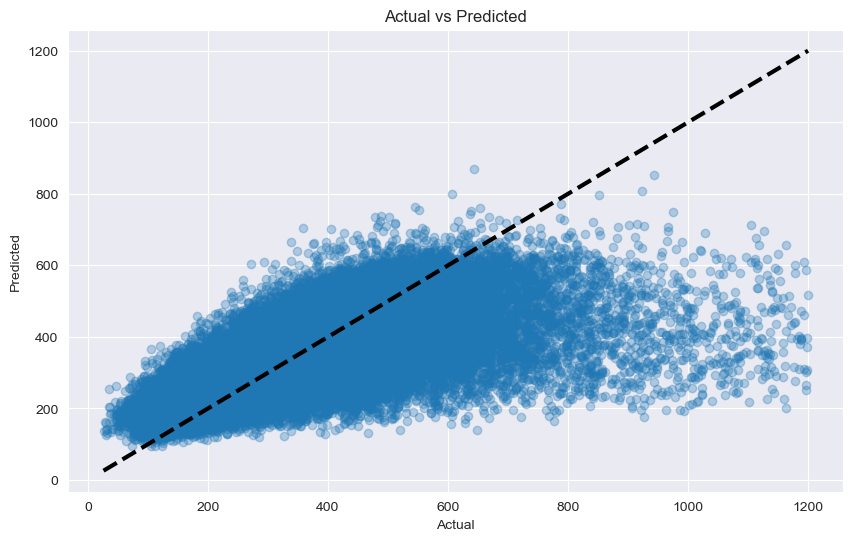

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


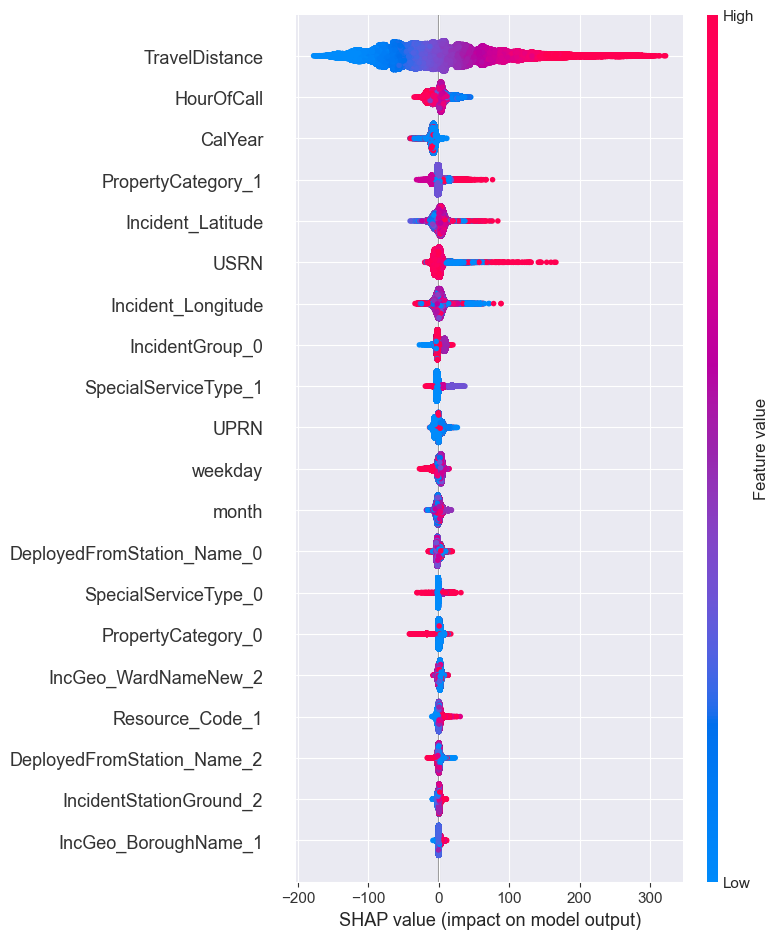

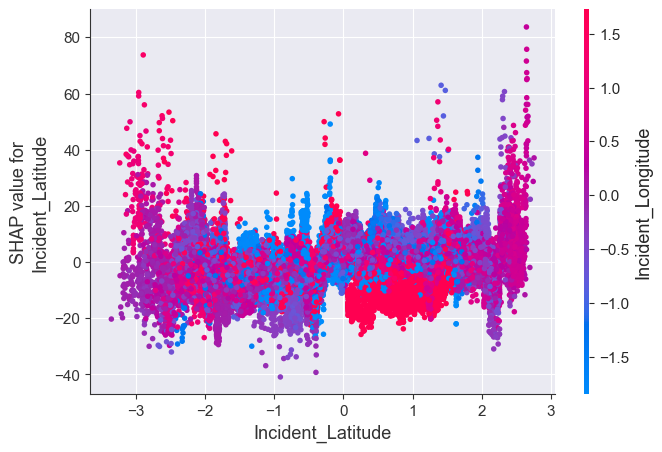

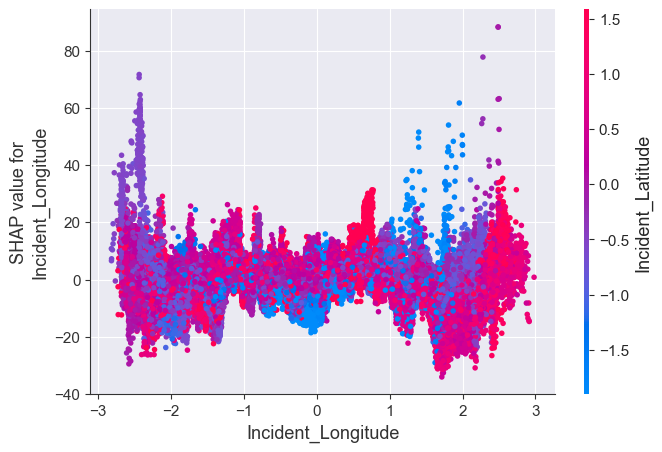

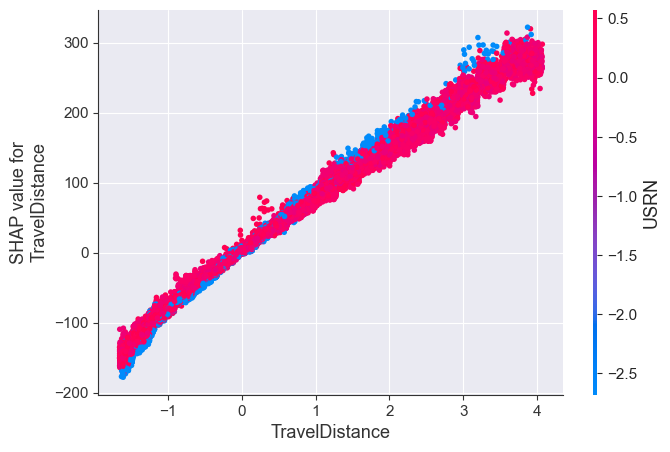

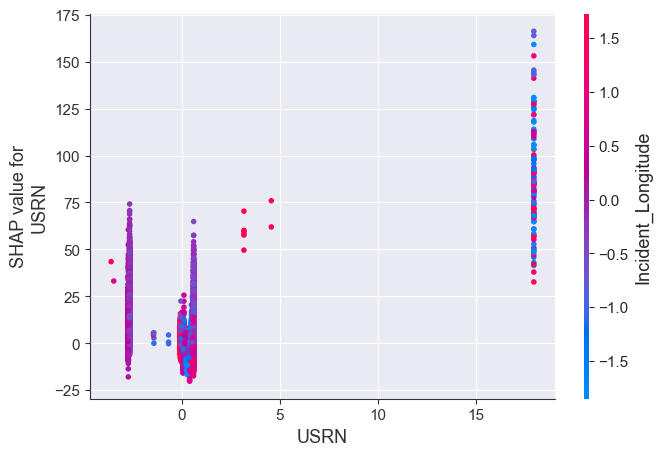

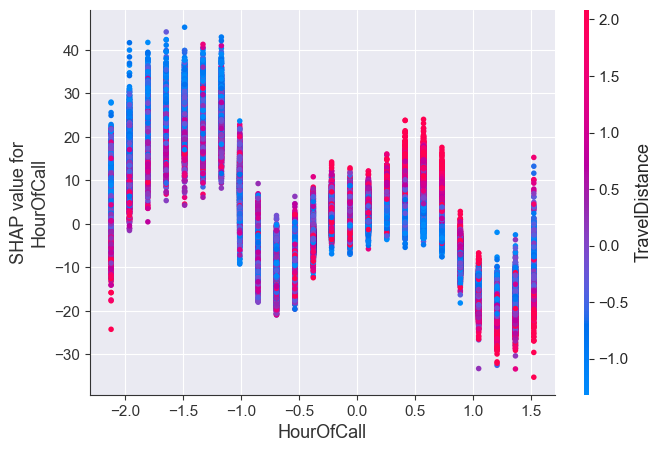

In [49]:
######################-------------------------- Try LightGBM-------------------------#################################

from skopt import BayesSearchCV
import numpy as np
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap

# Define feature_names from your DataFrame
feature_names = X_train_std.columns

lgb_model = lgb.LGBMRegressor(device="gpu")
lgb_model.fit(X_train_std, y_train)
y_pred_initial = lgb_model.predict(X_test_std)
mae_initial = mean_absolute_error(y_test, y_pred_initial)
print('Initial MAE:', mae_initial)

# Define the parameter space for the Bayesian optimization
param_space = {
    'device': ['gpu'],
    'subsample': (0.5, 1.0, 'uniform'),
    'n_estimators': (100, 1000),
    'max_depth': (3, 10, 'uniform'),
    'num_leaves': (15, 256),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
}

# Create the BayesSearchCV object with neg_mean_absolute_error scoring
lgb_model = lgb.LGBMRegressor(device="gpu")
bayes_search = BayesSearchCV(
    lgb_model,
    param_space,
    cv=3,
    n_iter=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# Fit the model
bayes_search.fit(X_train_std, y_train)
best_lgb_model = bayes_search.best_estimator_
print(best_lgb_model)

# Predict on the test set
y_pred = best_lgb_model.predict(X_test_std)

# Calculate evaluation metric
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# Obtain feature importance
feature_importance = best_lgb_model.feature_importances_

# Generate SHAP plots
explainer = shap.Explainer(best_lgb_model)
shap_values = explainer.shap_values(X_test_std)

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Generate SHAP plots
shap.summary_plot(shap_values, X_test_std)

for feature in sorted_feature_names[:5]:
    shap.dependence_plot(feature, shap_values, X_test_std)


##Classification

In [ ]:
##########--------- Differrent approaches to grouping the AttendanceTimeSeconds ------############

# Grouping 1: 4 groups within quantiles
df_num['AttendanceTimeSeconds'] = pd.qcut(x=df_num['AttendanceTimeSeconds'], q=4, labels=[0, 1, 2, 3])


# Grouping 2: 5 groups with equal seconds
df_num['AttendanceTimeSeconds'] = pd.cut(x=df_num['AttendanceTimeSeconds'], bins=[0, 240, 480, 720, 960, 1200], labels=[0, 1, 2, 3, 4])

# Grouping 3: K-means clustering
cluster_data = df_num[['AttendanceTimeSeconds']]
kmeans = KMeans(n_clusters=5, n_init=10).fit(cluster_data)
df_num['AttendanceTimeSeconds'] = kmeans.labels_

In [15]:
# Load data
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cleaned_df = pd.read_csv('../data/df_no_outliers.csv')

df_num = cleaned_df.copy()

######--------Choose grouping methode and try all of them--------############
df_num['AttendanceTimeSeconds'] = pd.qcut(x=df_num['AttendanceTimeSeconds'], q=4, labels=[0, 1, 2, 3])

columns_to_drop = ['Station_Latitude', 'Station_Longitude']
df_num = df_num.drop(columns_to_drop, axis=1)

train = df_num[df_num['CalYear'] < 2022]
test = df_num[df_num['CalYear'] >= 2022]

y_train, X_train = train['AttendanceTimeSeconds'], train.drop(['AttendanceTimeSeconds'], axis=1)
y_test, X_test = test['AttendanceTimeSeconds'], test.drop(['AttendanceTimeSeconds'], axis=1)

cats = X_train.select_dtypes(exclude=np.number).columns.tolist()


# BaseN Encoding
for col in cats:
    encoder = ce.BaseNEncoder(base=5)
    data_encoded = encoder.fit_transform(X_train[[col]])
    X_train = pd.concat([X_train, data_encoded], axis=1)
    X_train.drop(col, axis=1, inplace=True)

    data_encoded_test = encoder.transform(X_test[[col]])
    X_test = pd.concat([X_test, data_encoded_test], axis=1)
    X_test.drop(col, axis=1, inplace=True)


scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Accuracy: 0.5843376617604575
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72     34039
           1       0.47      0.48      0.47     33445
           2       0.47      0.46      0.47     33527
           3       0.70      0.64      0.67     33988

    accuracy                           0.58    134999
   macro avg       0.58      0.58      0.58    134999
weighted avg       0.58      0.58      0.58    134999



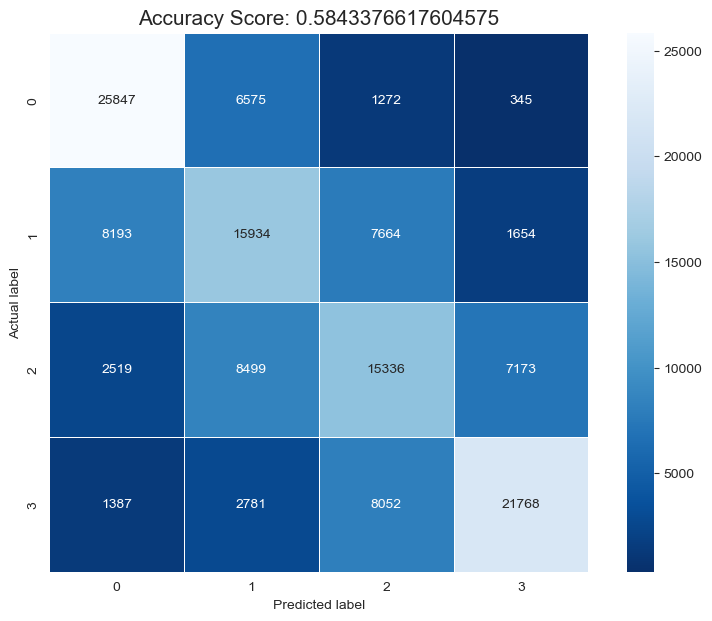

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


# Define the best parameters
best_params = {
    'colsample_bytree': 0.7738378854964503,
    'learning_rate': 0.12272370139788698,
    'max_depth': 8,
    'n_estimators': 856,
    'subsample': 0.8354417743729215,
    'tree_method': 'gpu_hist'
}

# Create and train the XGBoost model with the best parameters
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train_std, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_std)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore, support = score(y_test, y_pred)

# Print evaluation metrics
print('Accuracy:', accuracy)
print('Classification Report:')
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)

# Print the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);
plt.show()

MAE for error prediction: 41.7209225192454
Top 4 features for predicting error:
1. DeployedFromLocation_0: 0.09823115915060043
2. PropertyCategory_1: 0.07020730525255203
3. TravelDistance: 0.0498984158039093
4. IncidentGroup_0: 0.04250281676650047


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


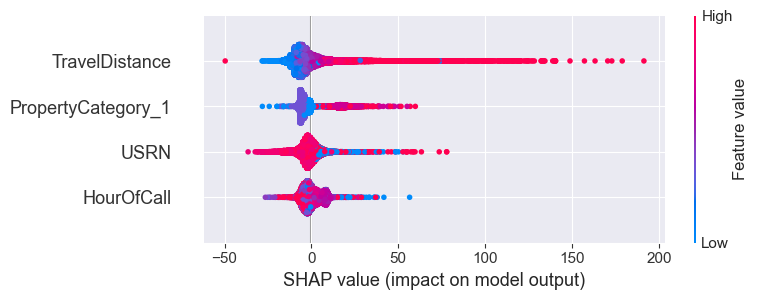

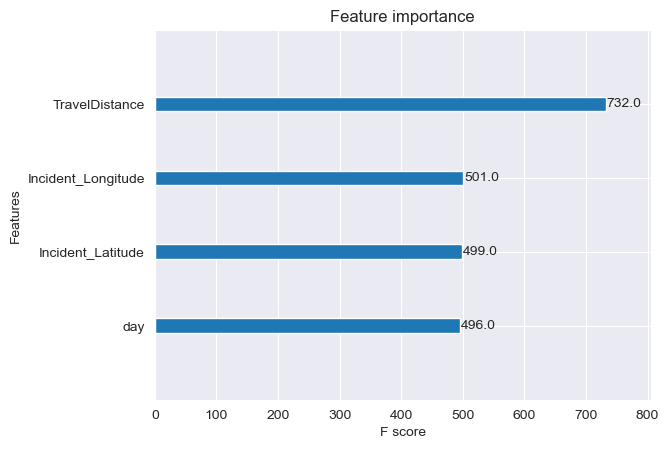

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


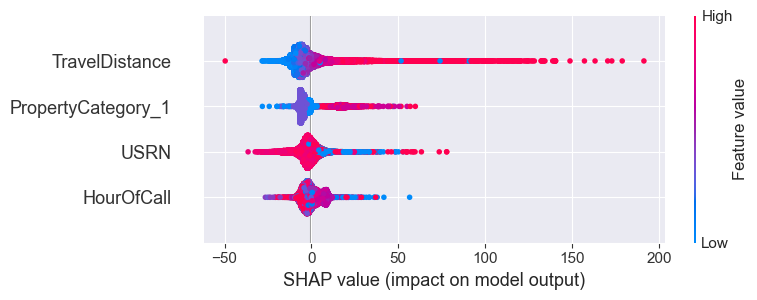

In [29]:
############-------------Lets see what has the main influence on the error of out model---############

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import shap
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/test.csv')

# 1. Add 'Absolute_Error' column to your dataframe
df['Absolute_Error'] = abs(df['AttendanceTimeSeconds'] - df['Predicted_AttendanceTimeSeconds'])

# 1.5 Remove unwanted columns
columns_to_drop = ['Station_Latitude', 'Station_Longitude','AttendanceTimeSeconds','Predicted_AttendanceTimeSeconds']
df = df.drop(columns_to_drop, axis=1)
cats = df.select_dtypes(exclude=np.number).columns.tolist()

# 2. Split the data into training and testing sets
X = df.drop(['Absolute_Error'], axis=1)
y = df['Absolute_Error']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in cats:
    encoder = ce.BaseNEncoder(base=5) ### base=2(binary encoding) or even 1(one-hot encoding) can be considered ( result in slightly better performance in XGBoost with significantly longer computation times)
    data_encoded = encoder.fit_transform(X_train[[col]])
    X_train = pd.concat([X_train, data_encoded], axis=1)
    X_train.drop(col, axis=1, inplace=True)

    data_encoded_test = encoder.transform(X_test[[col]])
    X_test = pd.concat([X_test, data_encoded_test], axis=1)
    X_test.drop(col, axis=1, inplace=True)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 3. Train an XGBoost model on the training data
xgb_model_error = xgb.XGBRegressor(
    tree_method="gpu_hist"
)
xgb_model_error.fit(X_train, y_train)

# 4. Make predictions on the testing data and evaluate the model's performance
y_pred_error = xgb_model_error.predict(X_test)
mae_error = mean_absolute_error(y_test, y_pred_error)
print("MAE for error prediction:", mae_error)

# 5. Use the feature importance information from the XGBoost model
feature_importance_error = xgb_model_error.feature_importances_
sorted_indices_error = np.argsort(feature_importance_error)[::-1]
sorted_feature_importance_error = feature_importance_error[sorted_indices_error]
sorted_feature_names_error = X_train.columns[sorted_indices_error]

# Print the top 4 features
print("Top 4 features for predicting error:")
for i in range(4):
    print(f"{i+1}. {sorted_feature_names_error[i]}: {sorted_feature_importance_error[i]}")

# If you want to see the effect of a particular feature on the model's predictions, you can use SHAP values.
# Here's how you can calculate and plot the SHAP values for the top feature:
explainer = shap.Explainer(xgb_model_error)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=4)

# 5. Use the feature importance information from the XGBoost model
xgb.plot_importance(xgb_model_error, max_num_features=4)
plt.show()

# 6. Use SHAP to interpret the model's predictions
explainer = shap.Explainer(xgb_model_error)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, max_display=4)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

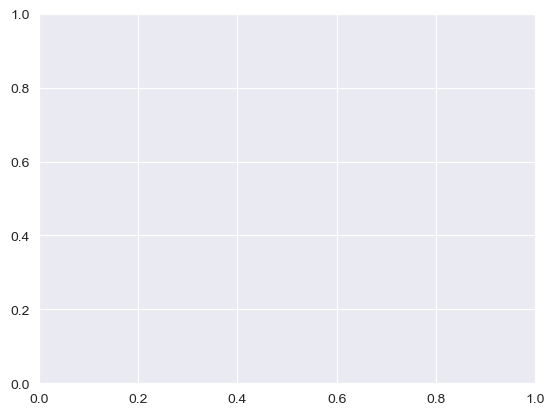

In [38]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming that 'xgb_model_error' is your trained XGBoost model
xgb.plot_tree(xgb_model_error, num_trees=0)
plt.show()

In [33]:
# Initialize JavaScript for SHAP
shap.initjs()

# Create a TreeExplainer for the model
explainer = shap.TreeExplainer(xgb_model_error)

# Calculate SHAP values for the first 1000 instances in the test set
shap_values = explainer.shap_values(X_test[:1000])

# Plot the SHAP values for the first instance in the test set
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])